In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import re
from ast import literal_eval
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [142]:
# load datasets info
f = open("rsc/datasets.json")
datasets = json.load(f)
f.close()

d = "adult" # FIXME: da levare una volta convertito in .py e prenderlo da linea di comand

In [143]:
results_df = pd.read_pickle("out/results/{}_exps.csv".format(d))

# parse lists
colss = ['s_groups', 'means_f', 'means_nf']

"""regex_pat = re.compile(r' +', flags=re.IGNORECASE)
for c in colss:
    results_df[c] = results_df[c].str.replace(regex_pat, " ", regex=True)
    results_df[c] = results_df[c].str.replace(" ", ",")   
results_df[colss] = results_df[colss].applymap(literal_eval)"""

'regex_pat = re.compile(r\' +\', flags=re.IGNORECASE)\nfor c in colss:\n    results_df[c] = results_df[c].str.replace(regex_pat, " ", regex=True)\n    results_df[c] = results_df[c].str.replace(" ", ",")   \nresults_df[colss] = results_df[colss].applymap(literal_eval)'

In [ ]:
algos = {
    "DILCA_M": {
        "color": "darksalmon",
        "linestyle": "--",
         "marker": "o",
         "label": "DILCA_M"
        },
    "DILCA_RR": {
        "color": "cornflowerblue",
        "linestyle": "--",
        "marker": "o",
        "label": "DILCA_RR"
    },
    "FairDILCA_FM": {
        "color": "red",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_M"    
    },
    "FairDILCA_FRR1": {
        "color": "blue",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_RR"    
    },
    "FairDILCA_FRR2": {
        "color": "orange",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_PL"    
    },
    "CorrelationRemover": {
        "color": "gold",
        "linestyle": "-",
        "marker": "d",
        "label": "CR"   
    },
    "NonFairOneHotEncoded": {
       "color": "violet",
        "linestyle": "--",
        "marker": "d",
        "label": "NFHE"    
    },
    "FairDILCA_BM": {
        "color": "salmon",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_BM"    
    },
    "FairDILCA_BRR": {
        "color": "green",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_BRR"    
    },
}

# Preliminary tests

In [ ]:
def plot_metric_new(ax, df, s, fm, metric, fd_mode, color="red", m=None):
    if fd_mode != 'D':
        df = df[(df['sensitive']== s) & (df['fair_method']== fm)]
        alphas = df['alpha']
        metrics =  df[metric]
        
        if len(alphas) > 1:
            ax.plot(alphas, metrics, label="FairDILCA-{}".format(fd_mode), color=color)
        else:
            ax.axhline(y=metrics.tolist()[0], label="FairDILCA-{}".format(fd_mode), color=color)
        ax.set_xlabel("Alpha")
        ax.set_title("{} ({}) - {}".format(d, s, fm))
    else:
        df = df[(df['fair_method'] == fm) & (df['method']==m) & (df['sensitive'] == s)]
        metrics = df[metric].unique()
        if len(metrics) > 0:
            metrics = df[metric].unique().tolist()[0]
        else: return
        ax.axhline(y=metrics, color=color, label="FairDILCA-{}".format(fd_mode))
        
def plot_f_nf_metric(ax, df, s, fm, metric, fd_mode, color="red", m=None):
    if fd_mode != "D":
        df = df[(df['sensitive']== s) & (df['fair_method']== fm)]
        alphas = df['alpha']
        metric_f = df[metric + "_f"]
        metric_nf = df[metric + "_nf"]
        if len(alphas) > 1:
            ax.plot(alphas, metric_f, label="FairDILCA-{} (fair)".format(fd_mode), color=color)
            ax.plot(alphas, metric_nf, label="FairDILCA-{} (non-fair)".format(fd_mode), color=color, alpha=0.5, linestyle="--")
        else:
            ax.axhline(y=metric_f.tolist()[0], label="FairDILCA-{} (fair)".format(fd_mode), color=color)
            ax.axhline(y=metric_nf.tolist()[0], label="FairDILCA-{} (non-fair)".format(fd_mode), color=color, alpha=0.5, linestyle="--")

        ax.set_title("{} ({}) - {}".format(d, s, fm))       
    else:
        df = df[(df['fair_method'] == fm) & (df['method']==m) & (df['sensitive'] == s)]
        if len(df[metric+'_f'].unique()) > 0:
            metrics_f = df[metric+'_f'].unique().tolist()[0]
            metrics_nf = df[metric+'_nf'].unique().tolist()[0]
        else: return
        ax.axhline(y=metrics_f, color=color, label="FairDILCA-{} (fair)".format(fd_mode))
        ax.axhline(y=metrics_nf, color=color, label="FairDILCA-{} (non fair)".format(fd_mode), linestyle='--')
        ax.set_title("{} ({}) - {}/{}".format(d, s, fm,m))

In [ ]:
if not os.path.exists("out/results/{}".format(d)): os.mkdir("out/results/{}".format(d))

Plotting per modalità e per metriche singole

In [144]:
metrics = ['pearson_objs','l1_dist_objs', 'pearson', 'time', 'f1', 'bcss']
f_nf_metrics = ['bcss']
group_metrics = ['means']
modes = ['CD', 'C', 'D']
modes_colors = ["red", "orange", "green"]

sensitives = results_df['sensitive'].unique()
fair_methods = ['FM', 'FRR1', 'FRR2']
contexts_df_d = [('B', 'M'), ('B', 'RR'), ('FRR2', 'RR')]
methods = [('M', 'FM'), ('RR', 'FRR1'), ('RR', 'FRR2')]

In [ ]:


for metr in metrics:
    fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))

    for x, mode in enumerate(modes):
        mode_df = results_df[(results_df['mode'] == mode) & (results_df['empty_context']== False)]
        
        if mode != 'D':
            for i, s in enumerate(sensitives):
                for j, fm in enumerate(fair_methods):
                    if len(sensitives) > 1: axs_temp = axs[i,j]
                    else: axs_temp = axs[j]
                    if metr in f_nf_metrics:
                        plot_f_nf_metric(axs_temp, mode_df, s, fm, metr, mode, color=modes_colors[x])
                    else:
                        plot_metric_new(axs_temp, mode_df, s, fm, metr, mode, color=modes_colors[x])
        else:
            for i, s in enumerate(sensitives):
                for j, (fm, m) in enumerate(contexts_df_d):
                    if len(sensitives) > 1: axs_temp = axs[i,j]
                    else: axs_temp = axs[j]
                    if metr in f_nf_metrics:
                        plot_f_nf_metric(axs_temp, mode_df, s, fm, metr, mode, color=modes_colors[x], m=m) 
                    else:
                        plot_metric_new(axs_temp, mode_df, s, fm, metr, mode, color=modes_colors[x], m=m)
    if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
    else: h1, l1 = axs[0].get_legend_handles_labels()
    fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
    fig.suptitle("{} {}".format(metr, d))    
    fig.tight_layout()  
    fig.savefig("out/results/{}/test_{}_{}.png".format(d, d, metr), bbox_inches='tight')

In [ ]:
methods_colors = ['orchid', "deepskyblue", "yellowgreen"]
for gm in group_metrics:
    for i, s in enumerate(sensitives):
        for x, mode in enumerate(modes):
            mode_df = results_df[results_df['mode'] == mode]
            groups_s= results_df[results_df['sensitive']==s]['s_groups'].to_list()[0]
            groups_s = [int(e) for e in groups_s]
            fig, axs = plt.subplots(1, len(groups_s), figsize=(4.5*len(groups_s), 4))
            
            if mode != "D":
                for j, fm in enumerate(fair_methods):
                    df = mode_df[(mode_df['fair_method']==fm) & (mode_df['sensitive']==s)]
                    metric_f = list(zip(*df[gm + "_f"].to_list()))
                    metric_nf = list(zip(*df[gm + "_nf"].to_list()))
                    majority_group = str(df['majority_group'].to_list()[0]).replace(".0", "")
                    alphas = df['alpha']
                    for g in range(len(metric_f)):
                        if len(alphas) > 1:
                            axs[g].plot(alphas, metric_f[g], label=gm + " (Dilca Fair-{} {})".format(mode, fm), color=methods_colors[j])
                            axs[g].plot(alphas, metric_nf[g], label=gm + " (Dilca NON Fair-{} {})".format(mode, fm), color=methods_colors[j], alpha=0.5)
                        else:
                            axs[g].axhline(y=metric_f[g], label=gm + " (Dilca Fair-{} {}/{})".format(mode, fm, m), color=methods_colors[j])
                            axs[g].axhline(y=metric_nf[g], label=gm + " (Dilca NON Fair-{} {}/{})".format(mode, fm, m), color=methods_colors[j], alpha=0.5, linestyle="--")
                        axs[g].set_xlabel('Alpha')
                        axs[g].set_title("MaG {} - MiG {}".format(majority_group, groups_s[g]))
            else:
                for j, (fm, m) in enumerate(contexts_df_d):
                        df = mode_df[(mode_df['fair_method']==fm) & (mode_df['sensitive']==s) & (mode_df['method']==m)]
                        metric_f = list(zip(*df[gm + "_f"].to_list()))
                        metric_nf = list(zip(*df[gm + "_nf"].to_list()))
                        if len(df['majority_group']) >0:
                            majority_group = str(df['majority_group'].to_list()[0]).replace(".0", "")
                        else: continue
                        for g in range(len(metric_f)):
                            axs[g].axhline(y=metric_f[g], label=gm + " (Dilca Fair-{} {}/{})".format(mode, fm, m), color=methods_colors[j])
                            axs[g].axhline(y=metric_nf[g], label=gm + " (Dilca NON Fair-{} {}/{})".format(mode, fm, m), color=methods_colors[j], alpha=0.5, linestyle="--")
                            axs[g].set_xlabel('Alpha')
                            axs[g].set_title("MaG {} - MiG {}".format(majority_group, groups_s[g]))
                    
            h1, l1 = axs[0].get_legend_handles_labels()
            fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)
            fig.suptitle("{} DilcaFair-{}: {} ({})".format(gm, mode, d, s), fontweight="bold", y=1.05)
            fig.tight_layout()
            fig.savefig("out/results/{}/test_{}_{}_{}_{}.png".format(d, d, gm, s, mode), bbox_inches='tight')

per modello

/var/folders/p0/56c71d2n0bg3czx0r3rs_wsh0000gn/T/ipykernel_1407/3196622637.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


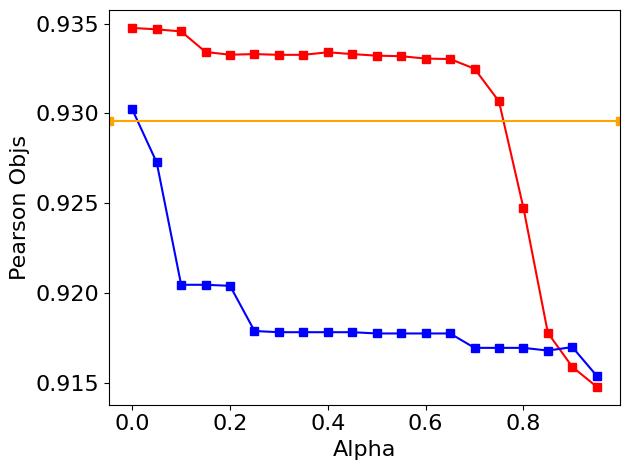

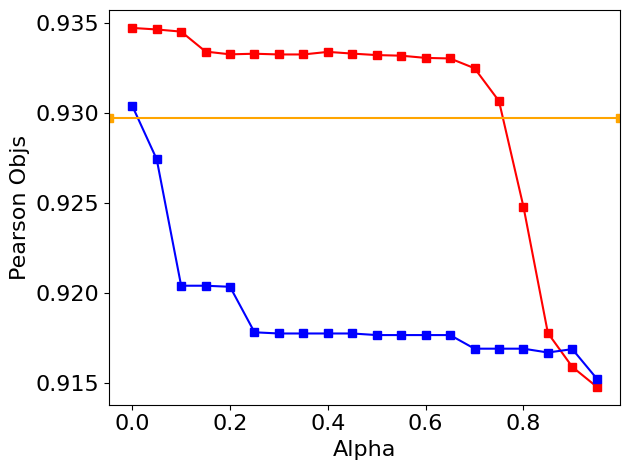

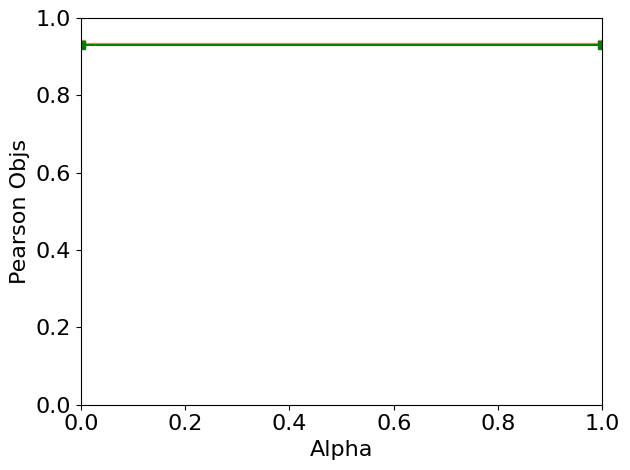

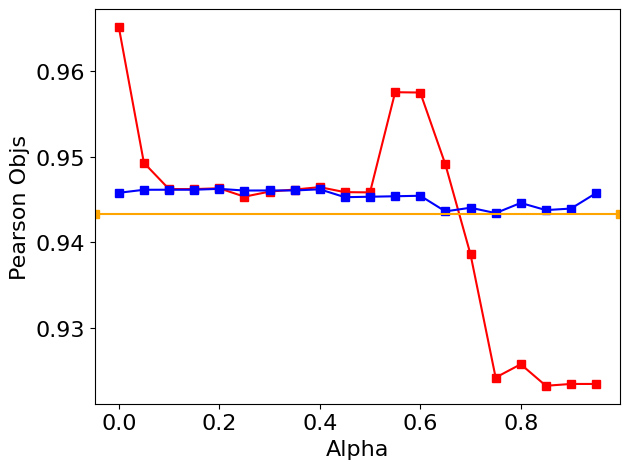

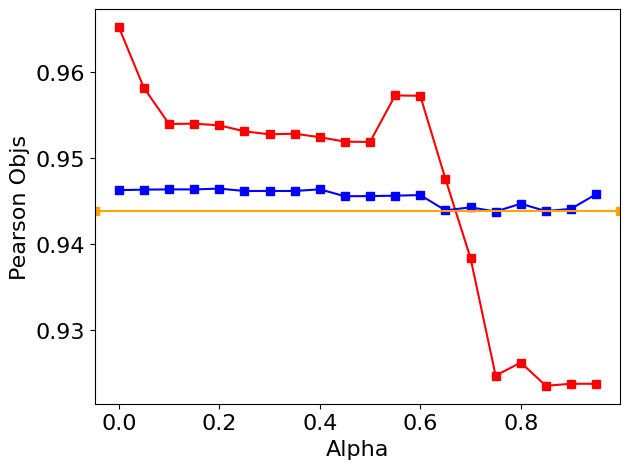

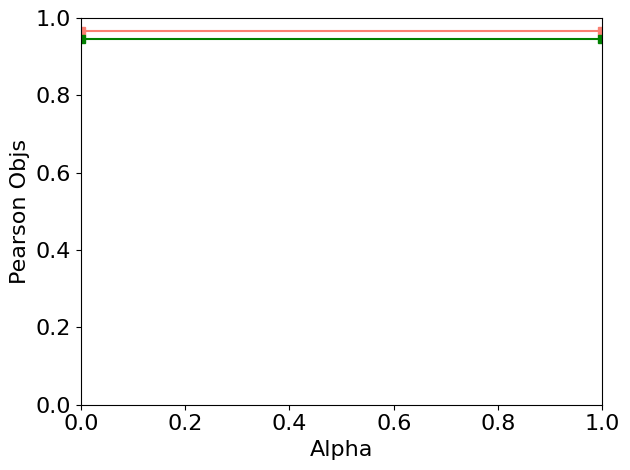

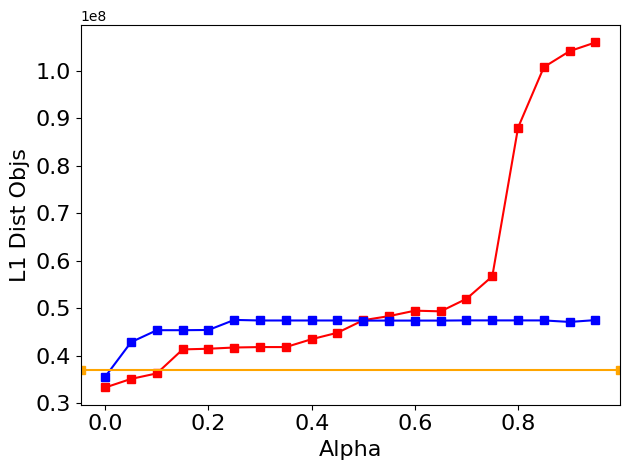

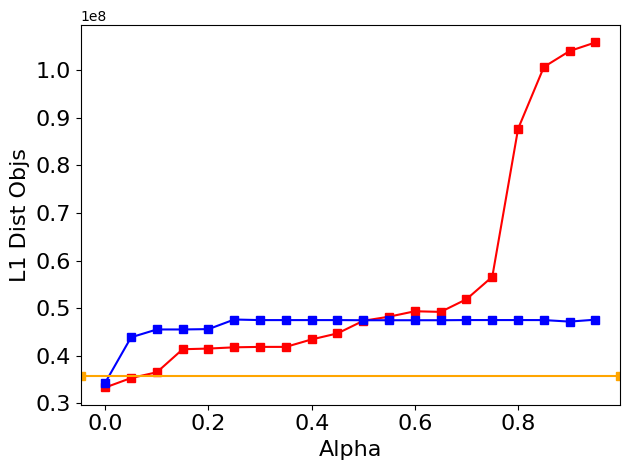

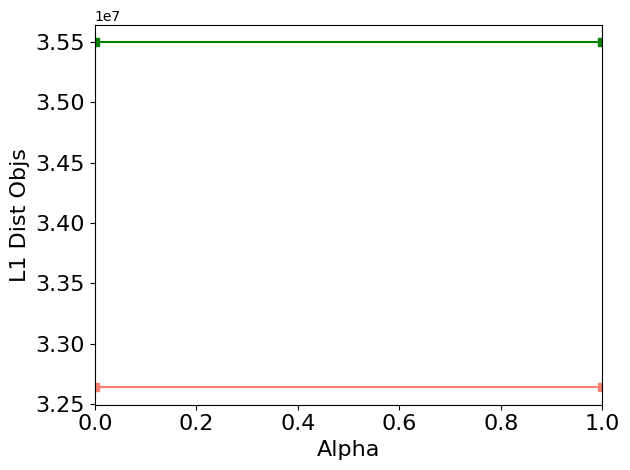

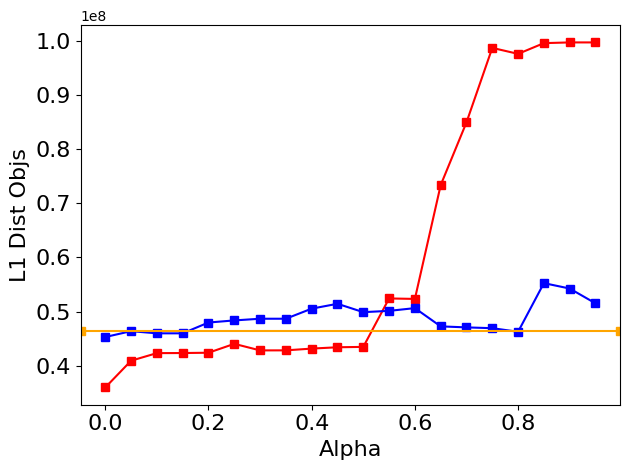

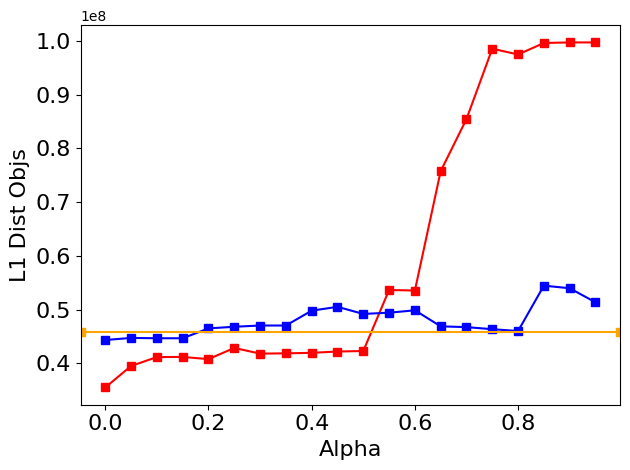

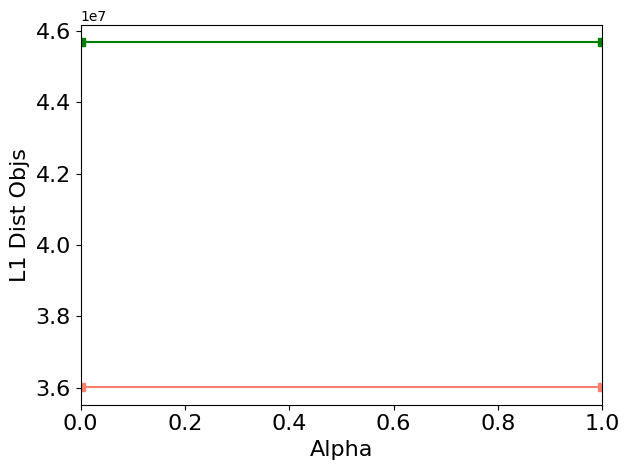

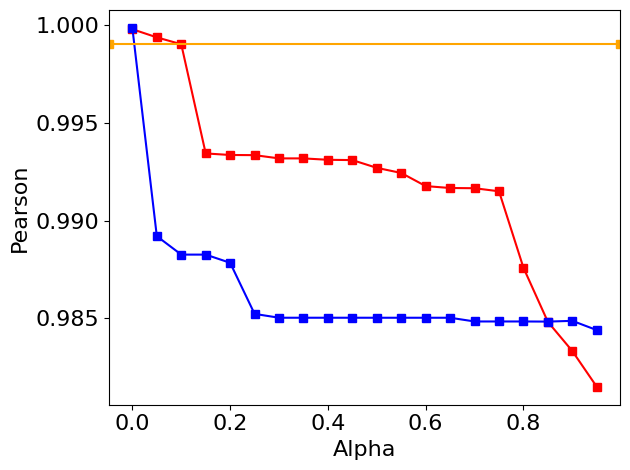

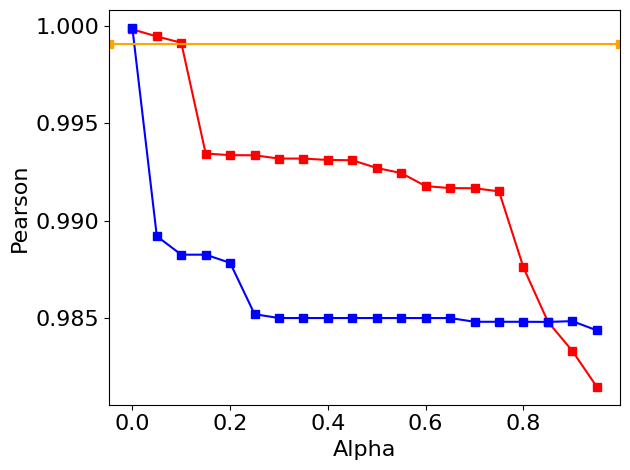

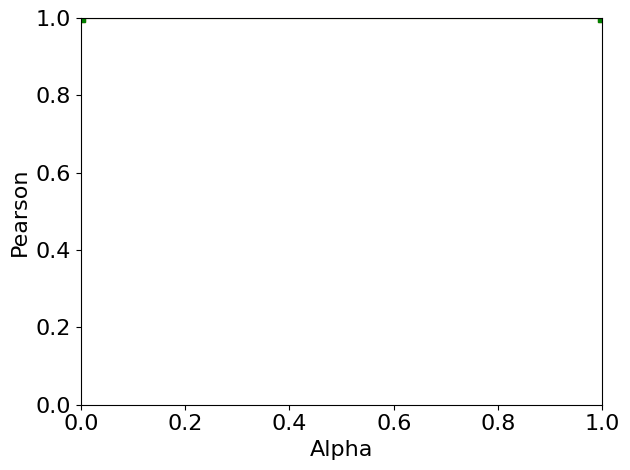

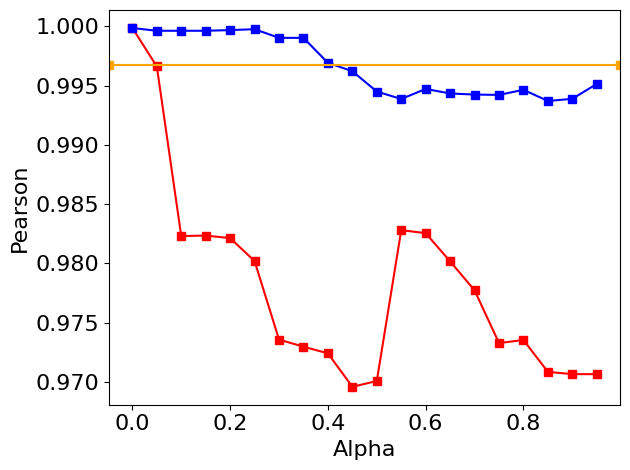

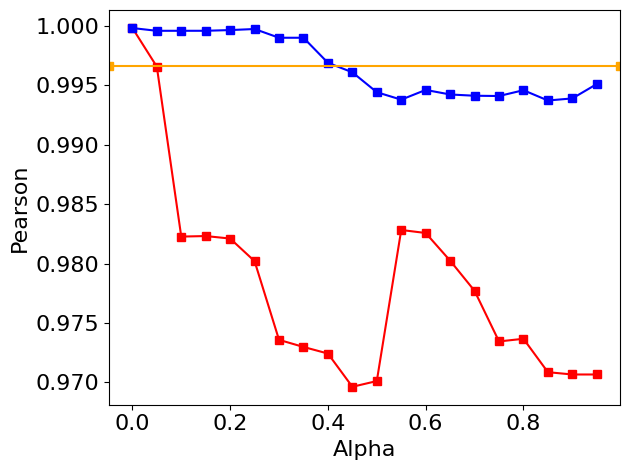

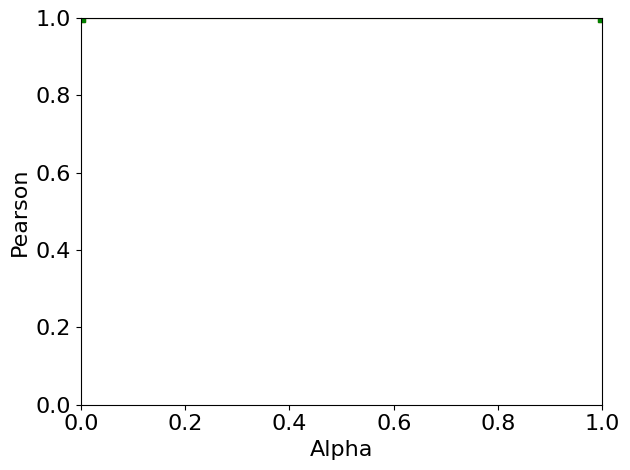

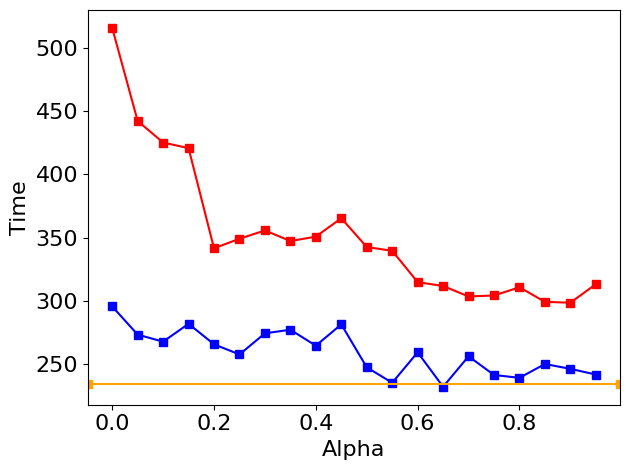

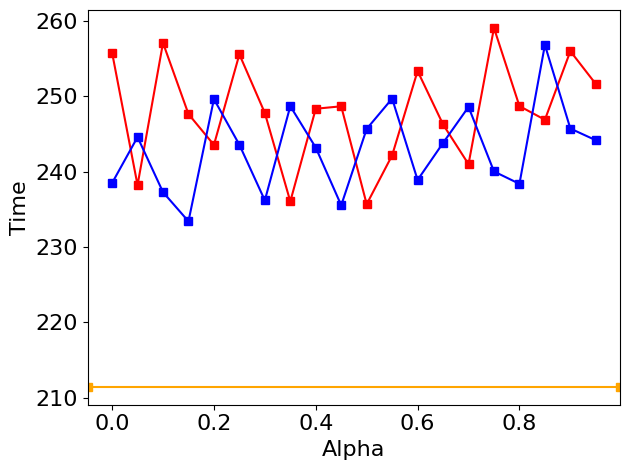

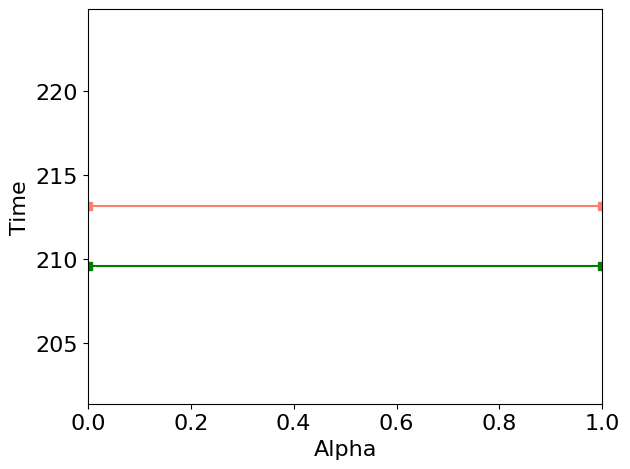

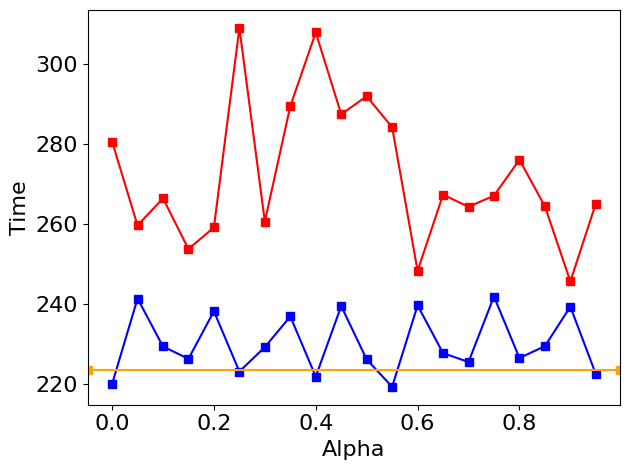

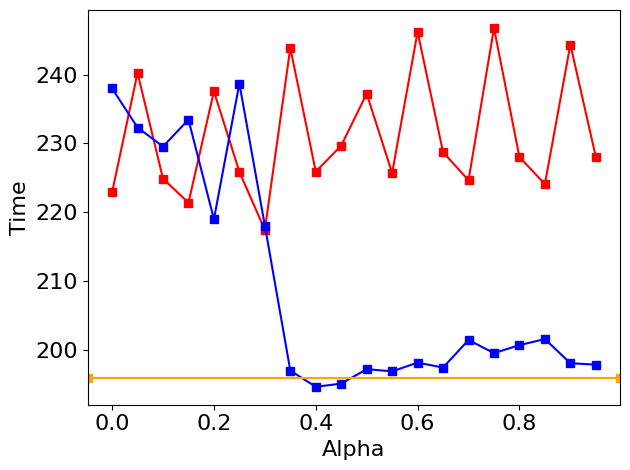

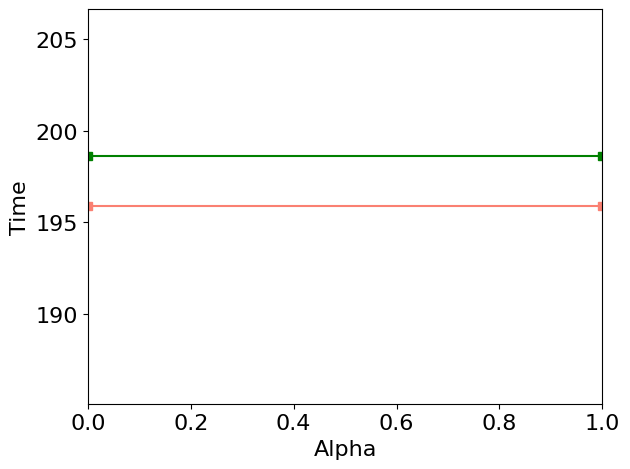

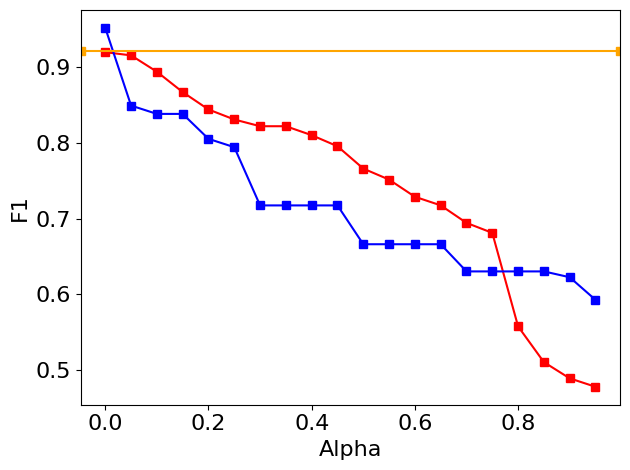

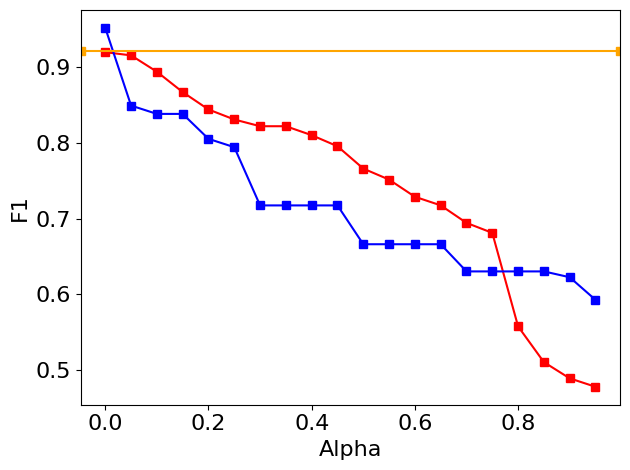

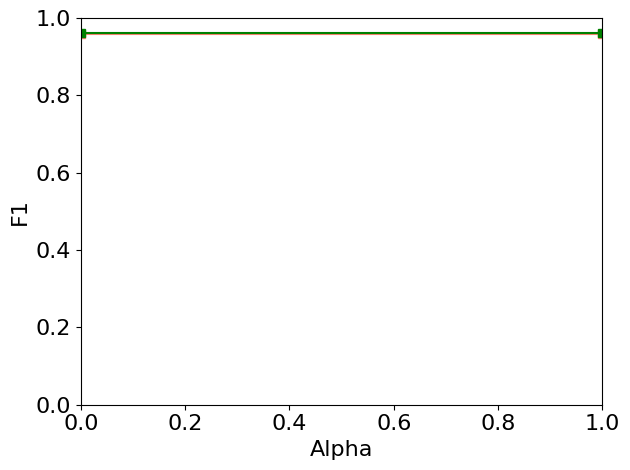

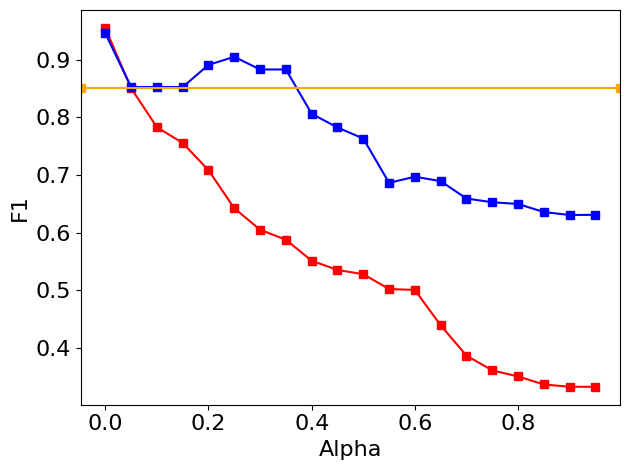

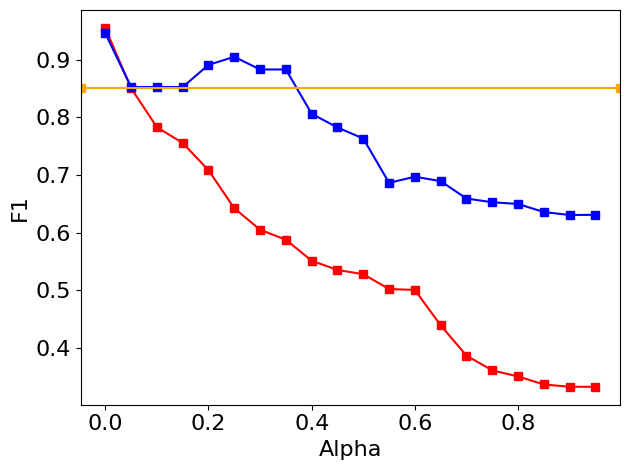

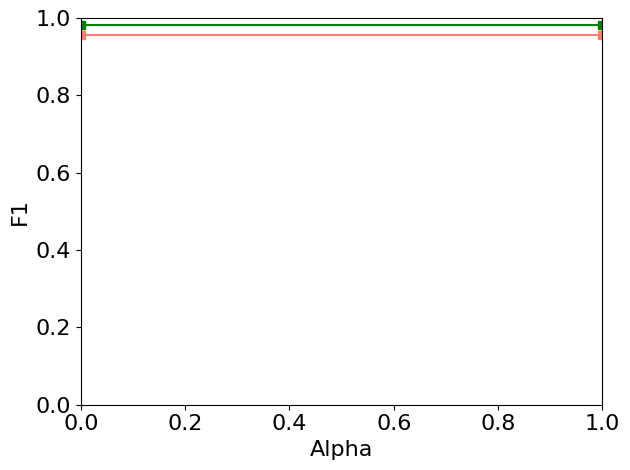

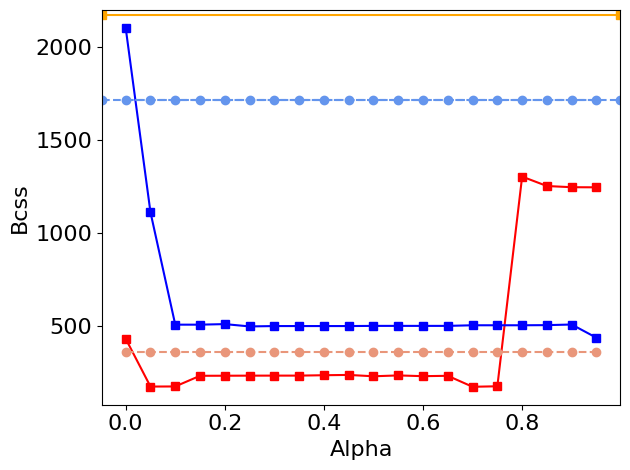

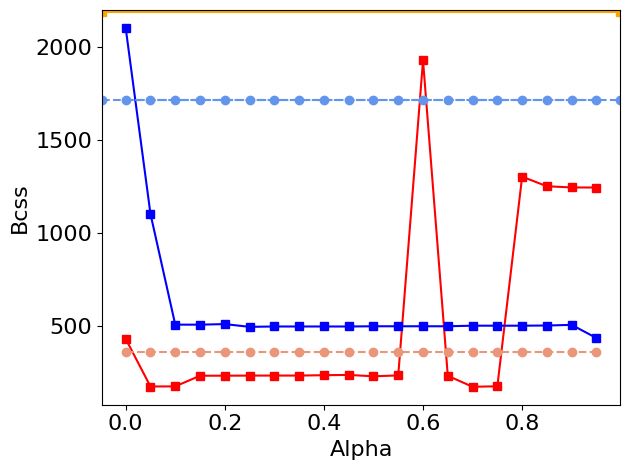

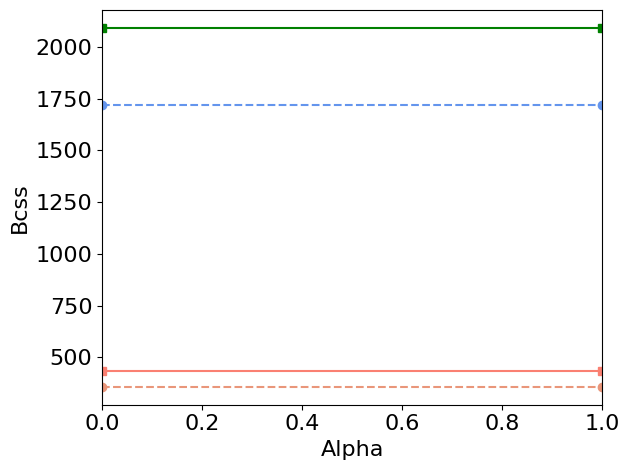

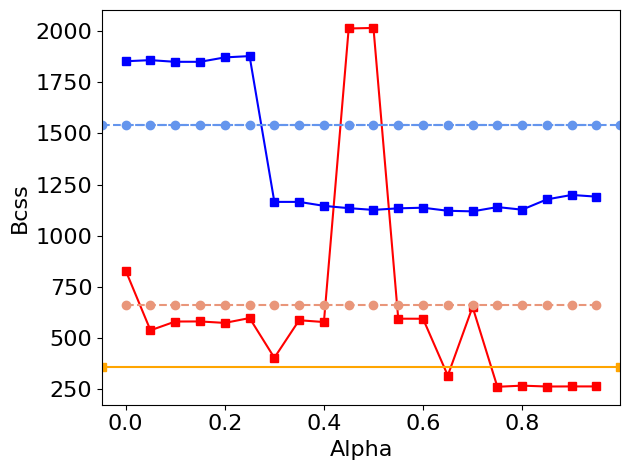

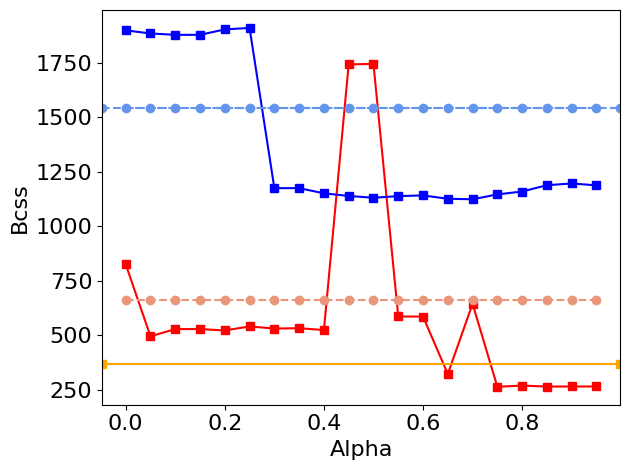

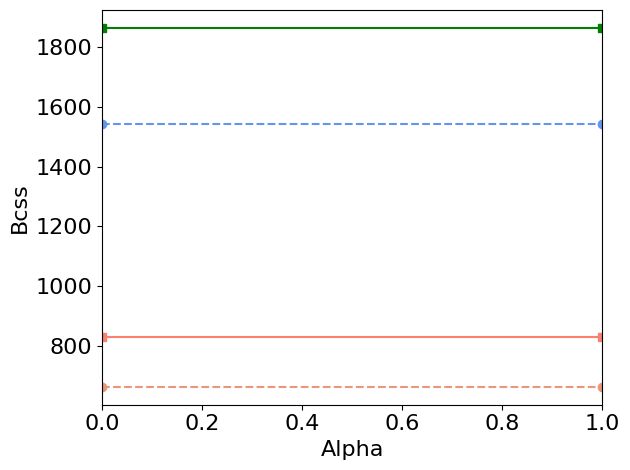

In [145]:

for metr in metrics:
    #fig, axs = plt.subplots(len(sensitives), len(modes), figsize=(4.5*len(modes), 4*len(sensitives)))
    handles = []
    labels = []
    for i, s in enumerate(sensitives):
        for x, mode in enumerate(modes):
            mode_df = results_df[results_df['mode'] == mode]
            
            fig, ax = plt.subplots()
            if mode != 'D':
                for j, (m, fm) in enumerate(methods):
                    df = mode_df[(mode_df['sensitive']== s) & (mode_df['fair_method']== fm)]
                    alphas = df['alpha']
                    
                    if metr not in f_nf_metrics:
                        metrics_data =  df[metr]
                        if len(alphas) > 1:
                            ax.plot(alphas, metrics_data, label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]["color"], marker=algos["FairDILCA_{}".format(fm)]["marker"], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"])
                        else:
                            ax.axhline(y=metrics_data.tolist()[0], label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]["color"], marker=algos["FairDILCA_{}".format(fm)]["marker"], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"])
                    else:
                        metrics_data_f = df[metr+'_f']
                        metrics_data_nf = df[metr+'_nf']
                        if len(alphas) > 1:
                            ax.plot(alphas, metrics_data_f, label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]["color"], marker=algos["FairDILCA_{}".format(fm)]["marker"], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"])
                            ax.plot(alphas, metrics_data_nf, label=algos["DILCA_{}".format(m)]["label"], color=algos["DILCA_{}".format(m)]["color"], marker=algos["DILCA_{}".format(m)]["marker"], linestyle=algos["DILCA_{}".format(m)]["linestyle"])
                        else:
                            ax.axhline(y=metrics_data_f.tolist()[0], label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]["color"], marker=algos["FairDILCA_{}".format(fm)]["marker"], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"])
                            ax.axhline(y=metrics_data_nf.tolist()[0], label=algos["DILCA_{}".format(m)]["label"], color=algos["DILCA_{}".format(m)]["color"], marker=algos["DILCA_{}".format(m)]["marker"], linestyle=algos["DILCA_{}".format(m)]["linestyle"])
                    handles.append(ax.get_legend_handles_labels()[0])
                    labels.append(ax.get_legend_handles_labels()[1])
            else:
                for j, (fm, m) in enumerate(contexts_df_d):
                    df = mode_df[(mode_df['fair_method']==fm) & (mode_df['sensitive']==s) & (mode_df['method']==m)]
                    if metr not in f_nf_metrics:
                        if len(df[metr].unique()) >0 :
                            metrics_data = df[metr].unique().tolist()[0]
                        else: continue
                        ax.axhline(y=metrics_data, label=algos["FairDILCA_{}{}".format(fm, m)]["label"], color=algos["FairDILCA_{}{}".format(fm, m)]["color"], marker=algos["FairDILCA_{}{}".format(fm, m)]["marker"], linestyle=algos["FairDILCA_{}{}".format(fm, m)]["linestyle"])
                    else:
                        if len(df[metr+"_f"].unique()) > 0:
                            metrics_data_f = df[metr+"_f"].unique().tolist()[0]
                            metrics_data_nf = df[metr+"_nf"].unique().tolist()[0]
                        else: continue
                        ax.axhline(y=metrics_data_f, label=algos["FairDILCA_{}{}".format(fm, m)]["label"], color=algos["FairDILCA_{}{}".format(fm, m)]["color"], marker=algos["FairDILCA_{}{}".format(fm, m)]["marker"], linestyle=algos["FairDILCA_{}{}".format(fm, m)]["linestyle"])
                        ax.axhline(y=metrics_data_nf,label=algos["DILCA_{}".format(m)]["label"], color=algos["DILCA_{}".format(m)]["color"], marker=algos["DILCA_{}".format(m)]["marker"], linestyle=algos["DILCA_{}".format(m)]["linestyle"])
                        handles.append(ax.get_legend_handles_labels()[0])
                        labels.append(ax.get_legend_handles_labels()[1])
            ax.set_xlabel("Alpha",  fontsize=16)
            ax.set_ylabel(metr.replace("_", " ").title(), fontsize=16)
            ax.tick_params(axis='x', labelsize=16)
            ax.tick_params(axis='y', labelsize=16) 
            fig.tight_layout()
            fig.savefig("out/results/{}/test_{}_{}_{}_FairDILCA_{}.png".format(d, d, s, metr, mode), bbox_inches='tight', dpi=300)
            fig.savefig("out/results/{}/test_{}_{}_{}_FairDILCA_{}.eps".format(d, d, s, metr, mode), bbox_inches='tight', dpi=300, format="eps") 
            fig.savefig("out/results/{}/test_{}_{}_{}_FairDILCA_{}.pdf".format(d, d, s, metr, mode), bbox_inches='tight', dpi=300, format="pdf") 
                                

## Legends

In [ ]:
order = ["DILCA_M", "DILCA_RR", "FairDILCA_M", "FairDILCA_RR", "FairDILCA_PL", "FairDILCA_BM", "FairDILCA_BRR"]
order = ["DILCA_M", "FairDILCA_BM", "FairDILCA_M", "DILCA_RR", "FairDILCA_BRR", "FairDILCA_PL", "FairDILCA_RR"]
labels = [item for row in labels for item in row]
handles = [item for row in handles for item in row]
dict_of_labels = dict(zip(labels, handles))
#dict_of_labels = dict(sorted(dict_of_labels.items()))
dict_of_labels = {key: dict_of_labels[key] for key in order}
empty_fig, axe = plt.subplots(figsize=(1, 0))
axe.legend(dict_of_labels.values(), dict_of_labels.keys(), loc="center", framealpha=1, frameon=True, bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=False, ncol=7, prop={'size': 22}, markerscale=2)
axe.xaxis.set_visible(False)
axe.yaxis.set_visible(False)
for v in axe.spines.values():
	v.set_visible(False)
 
empty_fig.savefig("out/results/{}/legend_.png".format(d), dpi=300, bbox_inches='tight')
empty_fig.savefig("out/results/{}/legend_.pdf".format(d), dpi=300, bbox_inches='tight', format="pdf")

empty_fig, axe = plt.subplots(figsize=(1, 1))
axe.legend(dict_of_labels.values(), dict_of_labels.keys(), loc="center", framealpha=1, frameon=True, prop={'size': 22}, markerscale=2)
axe.xaxis.set_visible(False)
axe.yaxis.set_visible(False)
for v in axe.spines.values():
	v.set_visible(False)
 
empty_fig.savefig("out/results/{}/legend.png".format(d), dpi=300, bbox_inches='tight')
empty_fig.savefig("out/results/{}/legend.pdf".format(d), dpi=300, bbox_inches='tight', format="pdf")


# Clustering tests

In [ ]:
results_df = pd.read_csv("out/results/exps_{}_clustering.csv".format(d), index_col=0)

In [ ]:
results_df = results_df[results_df['empty_context']==False]

In [ ]:
# parse lists
colss = ['mfc_f', 'mfc_nf', 'balance_f', 'balance_nf', 'entropy_f', 'entropy_nf', "groups"]
results_df['groups'] = results_df['groups'].str.replace(" ", ",")   

regex_pat = re.compile(r' +', flags=re.IGNORECASE)
for c in colss:
    results_df[c] = results_df[c].str.replace(regex_pat, " ", regex=True)
    #results_df[c] = results_df[c].str.replace(" ", ",")   
results_df[colss] = results_df[colss].applymap(literal_eval)

In [ ]:
def min_min(arr):
    return min(min(arr))

def max_max(arr):
    return max(max(arr))

def mean_array(list):
    return np.array(list).mean(axis=0)

def min_array(list):
    return np.array(list).min(axis=0)

def max_array(list):
    return np.array(list).max(axis=0)

# results_df['mfc_sv_f'] = results_df['mfc_f'].apply(max_max)
# results_df['mfc_sv_nf'] = results_df['mfc_nf'].apply(max_max)
# results_df['balance_sv_f'] = results_df['balance_f'].apply(min_min)
# results_df['balance_sv_nf'] = results_df['balance_nf'].apply(min_min)
# results_df['entropy_sv_f'] = results_df['entropy_f'].apply(max)
# results_df['entropy_sv_nf'] = results_df['entropy_nf'].apply(max)

results_df['balance_f_mean'] = results_df['balance_f'].apply(mean_array)
# results_df['balance_f_min'] = results_df['balance_f'].apply(min_array)
# results_df['balance_f_max'] = results_df['balance_f'].apply(max_array)

results_df['balance_nf_mean'] = results_df['balance_nf'].apply(mean_array)
# results_df['balance_nf_min'] = results_df['balance_nf'].apply(min_array)
# results_df['balance_nf_max'] = results_df['balance_nf'].apply(max_array)

results_df['mfc_f_mean'] = results_df['mfc_f'].apply(mean_array)
# results_df['mfc_min'] = results_df['mfc_f'].apply(min_array)
# results_df['mfc_max'] = results_df['mfc_f'].apply(max_array)

results_df['mfc_nf_mean'] = results_df['mfc_nf'].apply(mean_array)
# results_df['mfc_nf_min'] = results_df['mfc_nf'].apply(min_array)
# results_df['mfc_nf_max'] = results_df['mfc_nf'].apply(max_array)

#fm_gender_df['balance_f_mean'] = fm_gender_df['balance_f'].apply(mean_array)
#np.array(fm_gender_df['balance_f'][1]).mean(axis=0)

In [ ]:
clustering_types_colors = ['orchid', "deepskyblue", "yellowgreen"]
modes = ['C', 'CD']
f_nf_metrics = ['ari', 'nmi', 'mean_silhouette']
clustering_types = results_df['clustering_type'].unique()
sensitives = results_df['sensitive'].unique()
fair_methods = ['FM', 'FRR1', 'FRR2']
methods = results_df['method'].unique()

for metr in f_nf_metrics:
    for ct, clust_type in enumerate(clustering_types):
        fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))
        for x, mode in enumerate(modes):
            mode_df = results_df[results_df['mode'] == mode]
            for i, s in enumerate(sensitives):
                for j, fm in enumerate(fair_methods):
                    if len(sensitives) > 1: axs_temp = axs[i,j]
                    else: axs_temp = axs[j]
                    
                    df = mode_df[(mode_df['sensitive']== s) & (mode_df['fair_method']== fm) & (mode_df['clustering_type'] == clust_type)]
                    alphas = df['alpha']
                    
                    metrics_data_f = df[metr+'_f']
                    metrics_data_nf = df[metr+'_nf']
                    
                    if len(alphas) > 1:
                        axs_temp.plot(alphas, metrics_data_f, label="{} (fair)".format(mode), color=clustering_types_colors[x])
                        axs_temp.plot(alphas, metrics_data_nf, label="{} (non fair)".format(mode), color=clustering_types_colors[x], linestyle="--", alpha=0.5)
                    else:
                        axs_temp.axhline(y=metrics_data_f.tolist()[0], color=clustering_types_colors[x], label="{} (non fair)".format(mode))
                        axs_temp.axhline(y=metrics_data_nf.tolist()[0], color=clustering_types_colors[x], label="{} (non fair)".format(mode), linestyle="--", alpha=0.5)
                            
                    axs_temp.set_xlabel("Alpha")
                    axs_temp.set_title("{} ({}) - {}".format(d, s, fm))
                
        if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
        else: h1, l1 = axs[0].get_legend_handles_labels()
        fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)  
        fig.tight_layout()
        fig.suptitle("{} - {} - {}".format(d, metr, clust_type), fontweight="bold", y=1.05)
        fig.savefig("out/results/{}/test_clustering_{}_{}_{}.png".format(d, clust_type, d, metr), bbox_inches='tight')

In [ ]:
g_metrics = ['mfc', 'balance', 'entropy']
for metr in g_metrics:
    for ct, clust_type in enumerate(clustering_types):
        
        for x, mode in enumerate(modes):
            fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(10*len(fair_methods), 4*len(sensitives)))
            mode_df = results_df[results_df['mode'] == mode]
            for i, s in enumerate(sensitives):
                for j, fm in enumerate(fair_methods):
                    if len(sensitives) > 1: axs_temp = axs[i,j]
                    else: axs_temp = axs[j]
                    
                    df = mode_df[(mode_df['sensitive']== s) & (mode_df['fair_method']== fm) & (mode_df['clustering_type'] == clust_type)]
                    alphas = df['alpha']
                    
                    if len(alphas) == 0: continue

                    if metr == "entropy":
                        metrics_data_f = df[metr + "_f"]
                        metrics_data_nf = df[metr + "_nf"]
                    else:
                        metrics_data_f = df[metr + "_f_mean"]
                        metrics_data_nf = df[metr + "_nf_mean"]

                    metrics_group_data = [list(t) for t in zip(*metrics_data_f)]
                    metrics_group_data_nf = [list(t) for t in zip(*metrics_data_nf)]

                    metrics_group_data_nf = [gdnf[0] for gdnf in metrics_group_data_nf]

                    metrics_group_data_final = []
                    for ig in range(len(metrics_group_data_nf)):
                        metrics_group_data_final.append([metrics_group_data_nf[ig]] + metrics_group_data[ig])

                    groups = df['groups'].tolist()[0]

                    w = 1.0
                    num_x = len(alphas) + 1 
                    num_groups = len(groups) #stats.shape[0]
                    first_tick = int(math.ceil((num_groups*w/2)))
                    gap = num_groups*w + 1
                    x = np.array([first_tick + ix*gap for ix in range(num_x)])

                    b = []
                    for ig in range(num_groups):
                        b.append(axs_temp.bar(x - (ig - num_groups/2 + 0.5)*w, 
                                metrics_group_data_final[ig], 
                                width=w, 
                                align='center', 
                                edgecolor = 'black', 
                                linewidth = 1.0,
                                label = groups[ig] 
                                ))
                            
                    axs_temp.set_ylabel("Values")
                    axs_temp.set_xlabel('Alpha')
                    axs_temp.set_title("{} ({}) - {}".format(d, s, fm))
                    axs_temp.set_xticks(x)
                    axs_temp.set_xticklabels(["NF"] + [str(a) for a in alphas])
                    #ax.set_xticklabels(alphas)
                    """for i in range(num_groups):
                        ax.bar_label(b[i], 
                                    padding = 3,
                                    color = "white",
                                    label_type='center', 
                                    rotation = 'vertical')"""
                    axs_temp.legend()
            fig.tight_layout()
            fig.suptitle("{} - {} - {} | FairDilca {}".format(d, metr, clust_type, mode), fontweight="bold", y=1.05)
            fig.savefig("out/results/{}/test_clustering_{}_{}_{}_FairDilca-{}.png".format(d, clust_type, d, metr, mode), bbox_inches='tight')

# kNN tests

In [ ]:
results_df = pd.read_csv("out/results/exps_{}_knn.csv".format(d), index_col=0)
results_df = results_df[results_df['empty_context']==False]

In [ ]:
clustering_types_colors = ['orchid', "deepskyblue", "yellowgreen"]
modes = ['C', 'CD']
f_nf_metrics = ['accuracy', 'f1_macro', 'mcc', 'demographic_parity_diff', 'demographic_parity_ratio', 'equalized_odds_diff', 'equalized_odds_ratio', 'equal_opportunity_diff', 'equal_opportunity_ratio']
sensitives = results_df['sensitive'].unique()
fair_methods = ['FM', 'FRR1', 'FRR2']
methods = results_df['method'].unique()

for metr in f_nf_metrics:
	fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))
	for x, mode in enumerate(modes):
		mode_df = results_df[results_df['mode'] == mode]
		for i, s in enumerate(sensitives):
			for j, fm in enumerate(fair_methods):
				if len(sensitives) > 1: axs_temp = axs[i,j]
				else: axs_temp = axs[j]
				
				df = mode_df[(mode_df['sensitive']== s) & (mode_df['fair_method']== fm)]
				alphas = df['alpha']
				
				metrics_data_f = df[metr+'_f']
				metrics_data_nf = df[metr+'_nf']
				
				if len(alphas) > 1:
					axs_temp.plot(alphas, metrics_data_f, label="{} (fair)".format(mode), color=clustering_types_colors[x])
					axs_temp.plot(alphas, metrics_data_nf, label="{} (non fair)".format(mode), color=clustering_types_colors[x], linestyle="--", alpha=0.5)
				elif len(alphas) == 1:
					axs_temp.axhline(y=metrics_data_f.tolist()[0], color=clustering_types_colors[x], label="{} (non fair)".format(mode))
					axs_temp.axhline(y=metrics_data_nf.tolist()[0], color=clustering_types_colors[x], label="{} (non fair)".format(mode), linestyle="--", alpha=0.5)
						
				axs_temp.set_xlabel("Alpha")
				axs_temp.set_title("{} ({}) - {}".format(d, s, fm))
			
	if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
	else: h1, l1 = axs[0].get_legend_handles_labels()
	fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)  
	fig.tight_layout()
	fig.suptitle("{} - {}".format(d, metr), fontweight="bold", y=1.05)
	fig.savefig("out/results/{}/test_knn_{}_{}.png".format(d, d, metr), bbox_inches='tight')

# Competitors (CorrelationRemover)

In [ ]:
competitor = "CorrelationRemover"

## Exps

In [ ]:
results_competitors_df = pd.read_pickle("out/results/competitors/exps_{}_{}.csv".format(d, competitor))

In [ ]:
# Exps
exps_metrics = ["pearson_objs", "l1_dist_objs", "f1", "bcss"]
vs_metrics = ["bcss"]
exps_group_metrics = ["means"]
fair_methods = ['FM', 'FRR1', 'FRR2']
fd_methods = ["blue", "purple", "green"]
c_dilca_methods = ["red", "orange", "orange"]

sensitives = results_competitors_df['sensitive'].unique()


In [ ]:
for metr in exps_metrics:
    fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))
    for i, s in enumerate(sensitives):
        for j, fm in enumerate(fair_methods):
            if len(sensitives) > 1: axs_temp = axs[i,j]
            else: axs_temp = axs[j]
            df = results_competitors_df[(results_competitors_df['sensitive']== s) & (results_competitors_df['fair_method']== fm)]
            alphas = df['alpha']
            
            if metr in vs_metrics:
                metric_competitor = df[metr + "_dilca_competitor"]
                metric_fair_dilca = df[metr + "_fair_dilca"]
                
                if len(alphas) > 1:
                    axs_temp.plot(alphas, metric_competitor, label="DILCA on {}".format(competitor), color="r")
                    axs_temp.plot(alphas, metric_fair_dilca, label="FairDILCA", color="blue")
                else:
                    axs_temp.axhline(y=metric_competitor.to_list()[0], label="DILCA on {}".format(competitor), color="r")
                    axs_temp.axhline(y=metric_fair_dilca.tolist()[0], label="FairDILCA-{}".format(fm), color="blue")
            else: 
                metrics =  df[metr]
                if len(alphas) > 1:
                    axs_temp.plot(alphas, metrics, label="DILCA on {} ".format(competitor), color="r")
                else:
                    axs_temp.axhline(y=metrics.tolist()[0], label="DILCA on {} ".format(competitor), color="r")
            
            axs_temp.set_xlabel("Alpha")
            axs_temp.set_title("{} ({}) - {}".format(d, s, fm))
            
    if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
    else: h1, l1 = axs[0].get_legend_handles_labels()
    fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)  
    fig.suptitle("{} {}".format(metr, d))    
    fig.tight_layout()
    fig.savefig("out/results/competitors/{}/test_{}_{}.png".format(d, d, metr), bbox_inches='tight')

In [ ]:
for gm in exps_group_metrics:
    for i, s in enumerate(sensitives):
        groups_s= results_competitors_df[results_competitors_df['sensitive']==s]['s_groups'].to_list()[0]
        groups_s = [int(e) for e in groups_s]
        fig, axs = plt.subplots(1, len(groups_s), figsize=(4.5*len(groups_s), 4))
        
        for j, fm in enumerate(fair_methods):
            df = results_competitors_df[(results_competitors_df['fair_method']==fm) & (results_competitors_df['sensitive']==s)]
            metric_f = list(zip(*df[gm + "_competitor"].to_list()))
            metric_nf = list(zip(*df[gm + "_fair_dilca"].to_list()))
            majority_group = str(df['majority_group'].to_list()[0]).replace(".0", "")
            alphas = df['alpha']
            m = df['method'].unique()[0]
            for g in range(len(metric_f)):
                if len(alphas) > 1:

                    axs[g].plot(alphas, metric_f[g], label=gm + " DILCA ({}) on {}".format(m, competitor), color=c_dilca_methods[j])
                    axs[g].plot(alphas, metric_nf[g], label=gm + " FairDILCA ({})".format(fm), color=fd_methods[j])
                else:
                    if fm!="FRR2":
                        axs[g].axhline(y=metric_f[g], label=gm + " DILCA ({}) on {}".format(m, competitor), color=c_dilca_methods[j])
                    axs[g].axhline(y=metric_nf[g], label=gm + " FairDILCA", color=fd_methods[j])
                axs[g].set_xlabel('Alpha')
                axs[g].set_title("MaG {} - MiG {}".format(majority_group, groups_s[g]))
                            
        h1, l1 = axs[0].get_legend_handles_labels()
        fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)
        fig.suptitle("{} DilcaFair-{}:({})".format(gm, d, s), fontweight="bold", y=1.05)
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.png".format(d, d, gm, s), bbox_inches='tight')

## Clustering

In [ ]:
results_competitors_df = pd.read_pickle("out/results/competitors/exps_clustering_{}_{}.csv".format(d, competitor))

In [ ]:
clustering_types_colors = ['orchid', "deepskyblue", "yellowgreen"]
f_nf_metrics = ['ari', 'nmi', 'mean_silhouette']
clustering_types = results_competitors_df['clustering_type'].unique()
sensitives = results_competitors_df['sensitive'].unique()
fair_methods = ['FM', 'FRR1', 'FRR2']

methods = results_competitors_df['method'].unique()

In [ ]:
for metr in f_nf_metrics:
    for ct, clust_type in enumerate(clustering_types):
        fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))
        for i, s in enumerate(sensitives):
            for j, fm in enumerate(fair_methods):
                if len(sensitives) > 1: axs_temp = axs[i,j]
                else: axs_temp = axs[j]
                
                df = results_competitors_df[(results_competitors_df['sensitive']== s) & (results_competitors_df['fair_method']== fm) & (results_competitors_df['clustering_type'] == clust_type)]
                alphas = df['alpha']
                metric_competitor = df[metr + "_competitor"]
                metric_fair_dilca = df[metr + "_fd"]
                
                if len(alphas) > 1:
                    axs_temp.plot(alphas, metric_competitor, label="DILCA on {}".format(competitor), color="r")
                    axs_temp.plot(alphas, metric_fair_dilca, label="FairDILCA", color="blue")
                else:
                    axs_temp.axhline(y=metric_competitor.to_list()[0], label="DILCA on {}".format(competitor), color="r")
                    axs_temp.axhline(y=metric_fair_dilca.tolist()[0], label="FairDILCA-{}".format(fm), color="blue")
                axs_temp.set_xlabel("Alpha")
                axs_temp.set_title("{} ({}) - {}".format(d, s, fm))        
        if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
        else: h1, l1 = axs[0].get_legend_handles_labels()
        fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)  
        fig.tight_layout()
        fig.suptitle("{} - {} - {}".format(d, metr, clust_type), fontweight="bold", y=1.05)
        fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}.png".format(d, clust_type, d, metr), bbox_inches='tight')
                

In [ ]:
results_competitors_df[(results_competitors_df['sensitive']== "gender") & (results_competitors_df['fair_method']== "FM") & (results_competitors_df['clustering_type'] == "Agglomerative")]

In [ ]:
# mean array
def mean_array(list):
    return np.array(list).mean(axis=0)

results_competitors_df['balance_competitor_mean'] = results_competitors_df['balance_competitor'].apply(mean_array)

results_competitors_df['balance_fd_mean'] = results_competitors_df['balance_fd'].apply(mean_array)

results_competitors_df['mfc_competitor_mean'] = results_competitors_df['mfc_competitor'].apply(mean_array)

results_competitors_df['mfc_fd_mean'] = results_competitors_df['mfc_fd'].apply(mean_array)


In [ ]:
g_metrics = ['mfc', 'balance', 'entropy']
fair_methods = ['FM', 'FRR1']
for metr in g_metrics:
    for ct, clust_type in enumerate(clustering_types):
        for i, s in enumerate(sensitives):
            fig, axs = plt.subplots(2, len(fair_methods), figsize=(10*len(fair_methods), 4*len(sensitives)))
            for j, fm in enumerate(fair_methods):    
                df = results_competitors_df[(results_competitors_df['sensitive']== s) & (results_competitors_df['fair_method']== fm) & (results_competitors_df['clustering_type'] == clust_type)]
                alphas = df['alpha']
                
                if len(alphas) == 0: continue

                if metr == "entropy":
                    metrics_data_f = df[metr + "_competitor"]
                    metrics_data_nf = df[metr + "_fd"]
                else:
                    metrics_data_f = df[metr + "_competitor_mean"]
                    metrics_data_nf = df[metr + "_fd_mean"]

                metrics_group_data = [list(t) for t in zip(*metrics_data_f)]
                metrics_group_data_nf = [list(t) for t in zip(*metrics_data_nf)]

                groups = df['groups'].tolist()[0]

                w = 1.0
                num_x = len(alphas)
                num_groups = len(groups) #stats.shape[0]
                first_tick = int(math.ceil((num_groups*w/2)))
                gap = num_groups*w + 1
                x = np.array([first_tick + ix*gap for ix in range(num_x)])

                b = []
                for ig in range(num_groups):
                    b.append(axs[0][j].bar(x - (ig - num_groups/2 + 0.5)*w, 
                            metrics_group_data[ig], 
                            width=w, 
                            align='center', 
                            edgecolor = 'black', 
                            linewidth = 1.0,
                            label = groups[ig] 
                            ))
                axs[0][j].set_ylabel("Values")
                axs[0][j].set_xlabel('Alpha')
                axs[0][j].set_title("DILCA ({}) on {}".format(fm, competitor))
                axs[0][j].set_xticks(x)
                axs[0][j].set_xticklabels([str(a) for a in alphas])
                b = []
                for ig in range(num_groups):
                    b.append(axs[1][j].bar(x - (ig - num_groups/2 + 0.5)*w, 
                            metrics_group_data_nf[ig], 
                            width=w, 
                            align='center', 
                            edgecolor = 'black', 
                            linewidth = 1.0,
                            label = groups[ig] 
                            ))
                axs[1][j].set_ylabel("Values")
                axs[1][j].set_xlabel('Alpha')
                axs[1][j].set_title("FairDILCA ({})".format(fm))
                axs[1][j].set_xticks(x)
                axs[1][j].set_xticklabels([str(a) for a in alphas])
                
                #ax.set_xticklabels(alphas)
                """for i in range(num_groups):
                    ax.bar_label(b[i], 
                                padding = 3,
                                color = "white",
                                label_type='center', 
                                rotation = 'vertical')"""
                axs_temp.legend()
            fig.tight_layout()
            fig.suptitle("{} - {} ({}) - {} ".format(metr, d, s, clust_type), fontweight="bold", y=1.05)
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.png".format(d, clust_type, d, metr, s), bbox_inches='tight')
                           

## KNN

In [ ]:
results_competitors_df = pd.read_pickle("out/results/competitors/exps_knn_{}_{}.csv".format(d, competitor))

In [ ]:
f_nf_metrics = ['accuracy', 'f1_macro', 'mcc', 'demographic_parity_diff', 'demographic_parity_ratio', 'equalized_odds_diff', 'equalized_odds_ratio', 'equal_opportunity_diff', 'equal_opportunity_ratio']
sensitives = results_competitors_df['sensitive'].unique()
fair_methods = ['FM', 'FRR1', 'FRR2']

In [ ]:
for metr in f_nf_metrics:
	fig, axs = plt.subplots(len(sensitives), len(fair_methods), figsize=(4.5*len(fair_methods), 4*len(sensitives)))
	for i, s in enumerate(sensitives):
		for j, fm in enumerate(fair_methods):
			if len(sensitives) > 1: axs_temp = axs[i,j]
			else: axs_temp = axs[j]
			
			df = results_competitors_df[(results_competitors_df['sensitive']== s) & (results_competitors_df['fair_method']== fm)]
			alphas = df['alpha']
			
			metrics_data_competitor = df[metr+'_competitor']
			metrics_data_fd = df[metr+'_fd']
			
			if len(alphas) > 1:
				axs_temp.plot(alphas, metrics_data_competitor, label="DILCA on {}".format(competitor), color="r")
				axs_temp.plot(alphas, metrics_data_fd, label="FairDILCA", color="b")
			elif len(alphas) == 1:
				axs_temp.axhline(y=metrics_data_competitor.tolist()[0], color="r", label="DILCA on {}".format(competitor))
				axs_temp.axhline(y=metrics_data_fd.tolist()[0], color="b", label="FairDILCA")
					
			axs_temp.set_xlabel("Alpha")
			axs_temp.set_title("{} ({}) - {}".format(d, s, fm))
			
	if len(sensitives) > 1: h1, l1 = axs[0,0].get_legend_handles_labels()
	else: h1, l1 = axs[0].get_legend_handles_labels()
	fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=5)  
	fig.tight_layout()
	fig.suptitle("{} - {}".format(d, metr), fontweight="bold", y=1.05)
	fig.savefig("out/results/competitors/{}/test_knn_{}_{}.png".format(d, d, metr), bbox_inches='tight')

In [ ]:
d = "obesity"
filename = "out/results/competitors/knn_{}_CorrelationRemover.csv".format(d)

results = pd.read_pickle(filename)
results[:60]


In [ ]:
filename = "out/results/exps_{}_knn.csv".format(d)
results = pd.read_pickle(filename)
results[:60]

In [ ]:
from utils.data import load_dataset
for k in datasets.keys():
    dataset, X, Y = load_dataset(datasets[k], "rsc/originals/")
    print(k, Y.unique().shape[0])

# New charts

In [ ]:
"""algos = {
    "DILCA_M": {
        "color": "black",
        "linestyle": "--",
         "marker": "o",
         "label": "DILCA_M"
        },
    "DILCA_RR": {
        "color": "pink",
        "linestyle": "--",
        "marker": "o",
        "label": "DILCA_RR"
    },
    "FairDILCA_FM": {
        "color": "red",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_M"    
    },
    "FairDILCA_FRR1": {
        "color": "blue",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_RR"    
    },
    "FairDILCA_FRR2": {
        "color": "orange",
        "linestyle": "-",
        "marker": "s",
        "label": "FairDILCA_PL"    
    },
    "CorrelationRemover": {
        "color": "gold",
        "linestyle": "-",
        "marker": "d",
        "label": "CR"   
    },
    "NonFairOneHotEncoded": {
       "color": "violet",
        "linestyle": "--",
        "marker": "d",
        "label": "NFHE"    
    }
}
"""

In [176]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import re
from ast import literal_eval
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# load datasets info
f = open("rsc/datasets.json")
datasets = json.load(f)
f.close()

d = "bank_marketing"
competitor = "CorrelationRemover"
path_exps = "out/results/"
path_competitors = path_exps + "competitors/"

if not os.path.exists(path_exps): os.mkdir(path_exps)
if not os.path.exists(path_competitors): os.mkdir(path_competitors)
if not os.path.exists(path_competitors + "{}".format(d)): os.mkdir(path_competitors + "{}".format(d))

## Preliminary

True


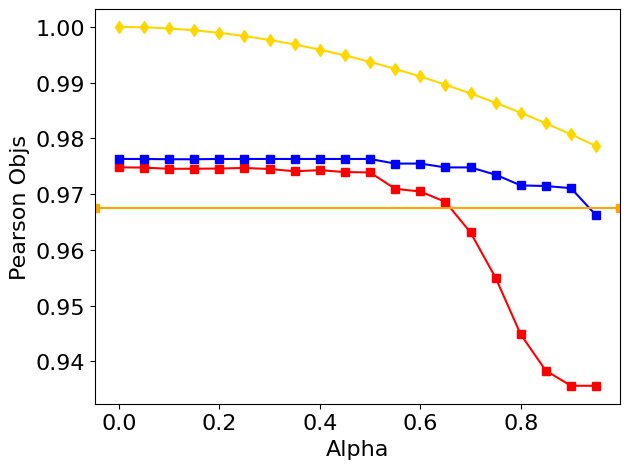

In [177]:

filename_dilca_fair_dilca = path_exps + "{}_exps.csv".format(d)
filename_dilca_competitor = path_competitors + "exps_{}_{}.csv".format(d, competitor)

results_dilca_fair_dilca = pd.read_pickle(filename_dilca_fair_dilca)
results_dilca_competitor = pd.read_pickle(filename_dilca_competitor)

results_dilca_competitor = results_dilca_competitor = results_dilca_competitor.rename(columns={"means_MaG-Migs_competitor": "means_MaG-MiGs_competitor", "means_MaG-Migs_dilca": "means_MaG-MiGs_dilca"})

sensitives = [s for s in results_dilca_fair_dilca['sensitive'].unique()]
sensitives2 = [s for s in results_dilca_competitor['sensitive'].unique()]
print(sensitives==sensitives2)

metrics = ["pearson_objs"]
contexts = [('M', 'FM'), ('RR', 'FRR1'), ('RR', 'FRR2')]

for metric in metrics:
    for s in sensitives:
        fig, axs = plt.subplots()
        # for DILCA based methods
        for m, fm in contexts:
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD') ]
            alphas = df['alpha']
            metric_data = df[metric]

            if fm=='FRR2':
                axs.axhline(y=metric_data.tolist()[0], label=algos["FairDILCA_{}".format(fm)]['label'], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
            else:
                axs.plot(alphas, metric_data, label=algos["FairDILCA_{}".format(fm)]['label'], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
        # for competitors
        competitor_context = ['']
        for m in competitor_context:
            df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m)]
            alphas = results_dilca_fair_dilca['alpha'].unique()
            metric_data = df[metric+"_original"]
            
            axs.plot(alphas, metric_data, label=algos[competitor]["label"], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
        
        axs.set_xlabel("Alpha", fontsize=16)
        axs.set_ylabel(metric.replace("_", " ").title(), fontsize=16)
        h, l = axs.get_legend_handles_labels()
        #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
        #fig.suptitle("{} ({}) - {}".format(d, s, metric.replace("_", " ").title()))   
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16) 
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.png".format(d, d, s, metric), bbox_inches='tight', dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.eps".format(d, d, s, metric), bbox_inches='tight', format="eps", dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.pdf".format(d, d, s, metric), bbox_inches='tight', format="pdf", dpi=300)

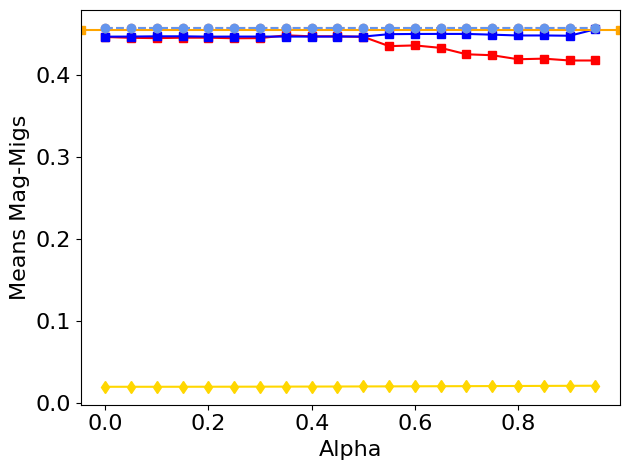

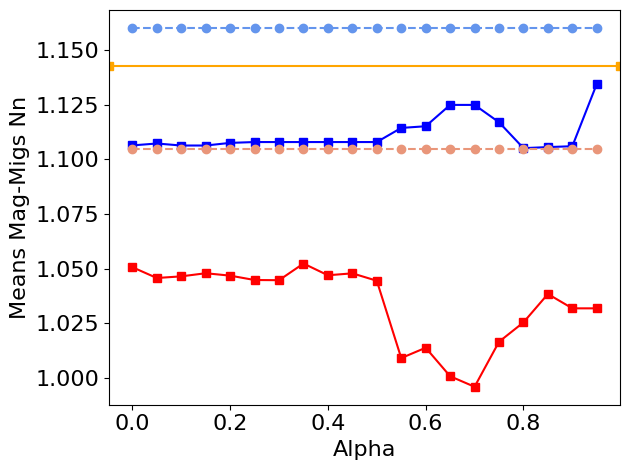

In [178]:
metrics = ['means_MaG-MiGs', 'means_MaG-MiGs_nn']
# DILCA-FairDILCA
for metric in metrics:
    for s in sensitives:
        fig, axs = plt.subplots()
        # for FairDILCA 
        for m, fm in contexts:
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD')]
            alphas = df['alpha']
            metric_data = df[metric+'_f']

            if fm=='FRR2':
                axs.axhline(y=metric_data.tolist()[0], label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
            else:
                axs.plot(alphas, metric_data, label=algos["FairDILCA_{}".format(fm)]['label'], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
        # for DILCA
        for m, fm in contexts[:2]:
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD')]
            alphas = df['alpha']
            metric_data = df[metric+'_nf']

            axs.plot(alphas, metric_data, label=algos["DILCA_{}".format(m)]['label'], color=algos["DILCA_{}".format(m)]['color'], linestyle=algos["DILCA_{}".format(m)]["linestyle"], marker=algos["DILCA_{}".format(m)]["marker"])
        # for Competitors
        if metric != "means_MaG-MiGs_nn":
            for m in ['']:
                df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m)]
                alphas = results_dilca_fair_dilca['alpha'].unique()
                metric_data = df[metric+'_competitor']
                axs.plot(alphas, metric_data, label=algos[competitor]["label"], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16) 
        axs.set_xlabel("Alpha", fontsize=16)
        axs.set_ylabel(metric.replace("_", " ").title(), fontsize=16)
        h, l = axs.get_legend_handles_labels()
        #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
        #fig.suptitle("{} ({}) - {}".format(d, s, "MaGvsRest"))    
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.png".format(d, d, s, metric), bbox_inches='tight', dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.eps".format(d, d, s, metric), bbox_inches='tight', format="eps", dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.pdf".format(d, d, s, metric), bbox_inches='tight', format="pdf", dpi=300)

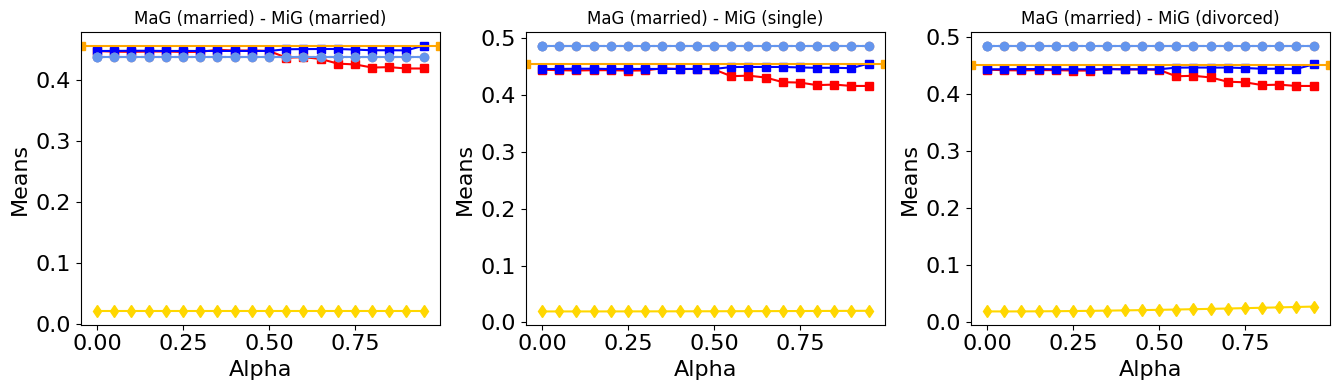

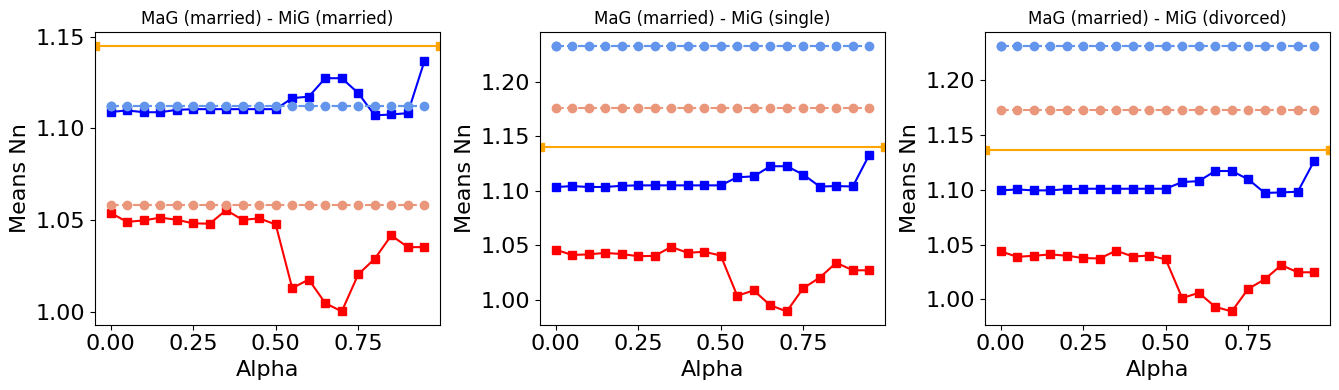

In [179]:
metrics = ["means", "means_nn"]
# DILCA-FairDILCA
for metric in metrics:
    for s in sensitives:
        groups = results_dilca_fair_dilca[results_dilca_fair_dilca['sensitive']==s]['s_groups'].to_list()[0]
        fig, axs = plt.subplots(1, len(groups), figsize=(4.5*len(groups), 4))
        # FairDILCA
        for m, fm in contexts:
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['mode']== 'CD')]
            alphas = df['alpha']
            majority_group = df['majority_group'].to_list()[0]
            metric_fair_dilca = list(zip(*df[metric + "_f"].to_list()))
            for g in range(len(metric_fair_dilca)):
                if fm == "FRR2": axs[g].axhline(y=metric_fair_dilca[g], label=algos["FairDILCA_{}".format(fm)]['label'], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]['linestyle'], marker=algos["FairDILCA_{}".format(fm)]["marker"])
                else: axs[g].plot(alphas, metric_fair_dilca[g], label=algos["FairDILCA_{}".format(fm)]['label'], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]['linestyle'], marker=algos["FairDILCA_{}".format(fm)]["marker"]) 
                axs[g].tick_params(axis='x', labelsize=16)
                axs[g].tick_params(axis='y', labelsize=16) 
                axs[g].set_xlabel('Alpha', fontsize=16)
                axs[g].set_ylabel(metric.replace("_", " ").title(), fontsize=16)
                axs[g].set_title("MaG ({}) - MiG ({})".format(majority_group, groups[g]))
        # DILCA
        for m in ["M", "RR"]:
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD')]
            alphas = df['alpha']
            majority_group = df['majority_group'].to_list()[0]
            metric_dilca = list(zip(*df[metric +  "_nf"].to_list()))
            for g in range(len(metric_dilca)):
                axs[g].plot(alphas, metric_dilca[g], label=algos["DILCA_{}".format(m)]['label'], color=algos["DILCA_{}".format(m)]['color'], marker=algos["DILCA_{}".format(m)]["marker"], linestyle=algos["DILCA_{}".format(m)]['linestyle']) 
        # Competitor
        if metric != "means_nn":
            for m in ['']:
                df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m)]
                alphas = results_dilca_fair_dilca['alpha'].unique()
                metric_competitor = list(zip(*df[metric + "_competitor"].to_list()))
                for g in range(len(metric_competitor)):
                    axs[g].plot(alphas, metric_competitor[g], label=algos[competitor]['label'], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])

        h1, l1 = axs[0].get_legend_handles_labels()
        #fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))
        #fig.suptitle("{} ({}) - {}".format(d, s, metric.replace("_", " ").title()))    
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.png".format(d, d, s, metric), bbox_inches='tight', dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.eps".format(d, d, s, metric), bbox_inches='tight', format="eps", dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}.pdf".format(d, d, s, metric), bbox_inches='tight', format="pdf", dpi=300)      
            

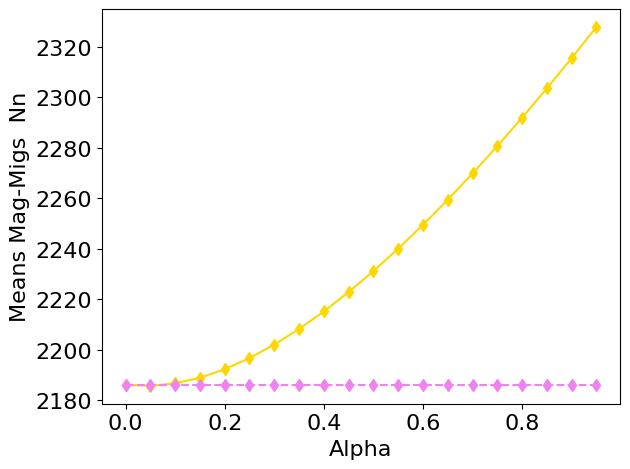

In [180]:
# Competitor
metrics = ['means_MaG-Migs_{}_nn']

for metric in metrics:
    for s in sensitives:
        fig, axs = plt.subplots()
        # for Competitors
        df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== '')]
        alphas = results_dilca_fair_dilca['alpha'].unique()
        metric_data = df[metric.format("competitor")]
        axs.plot(alphas, metric_data, label=algos[competitor]["label"], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
        
        metric_data = df[metric.format("dilca")]
        axs.plot(alphas, metric_data, label=algos["NonFairOneHotEncoded"]["label"], color=algos["NonFairOneHotEncoded"]['color'], linestyle=algos["NonFairOneHotEncoded"]["linestyle"], marker=algos["NonFairOneHotEncoded"]["marker"])
        
        axs.tick_params(axis='x', labelsize=16)
        axs.tick_params(axis='y', labelsize=16) 
        axs.set_xlabel("Alpha", fontsize=16)
        axs.set_ylabel(metric.format("").replace("_", " ").title(), fontsize=16)
        h, l = axs.get_legend_handles_labels()
        #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
        #fig.suptitle("{} ({}) - {}".format(d, s, "MaGvsRest"))    
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.png".format(d, d, s, metric.format("")), bbox_inches='tight', dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.eps".format(d, d, s, metric.format("")), bbox_inches='tight', format="eps", dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.pdf".format(d, d, s, metric.format("")), bbox_inches='tight', format="pdf", dpi=300)

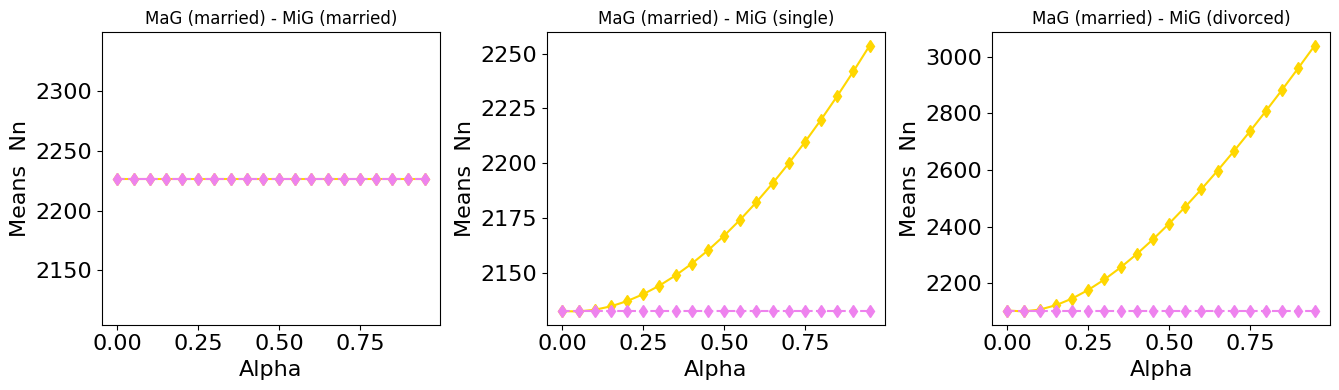

In [181]:
# Competitor
metrics = ["means_{}_nn"]

for metric in metrics:
    for s in sensitives:
        groups = results_dilca_fair_dilca[results_dilca_fair_dilca['sensitive']==s]['s_groups'].to_list()[0]
        fig, axs = plt.subplots(1, len(groups), figsize=(4.5*len(groups), 4))
    
        df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== '')]
        majority_group = df['majority_group'].to_list()[0]
        alphas = results_dilca_fair_dilca['alpha'].unique()
        metric_competitor = list(zip(*df[metric.format("competitor")].to_list()))
        for g in range(len(metric_competitor)):
            axs[g].plot(alphas, metric_competitor[g], label=algos[competitor]['label'], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
            axs[g].tick_params(axis='x', labelsize=16)
            axs[g].tick_params(axis='y', labelsize=16) 
            axs[g].set_xlabel('Alpha', fontsize=16)
            axs[g].set_ylabel(metric.format('').replace("_", " ").title(), fontsize=16)
            axs[g].set_title("MaG ({}) - MiG ({})".format(majority_group, groups[g]))
        metric_competitor = list(zip(*df[metric.format("dilca")].to_list()))
        for g in range(len(metric_competitor)):
            axs[g].plot(alphas, metric_competitor[g], label=algos["NonFairOneHotEncoded"]['label'], color=algos["NonFairOneHotEncoded"]['color'], linestyle=algos["NonFairOneHotEncoded"]["linestyle"], marker=algos["NonFairOneHotEncoded"]["marker"])
            
        h1, l1 = axs[0].get_legend_handles_labels()
        #fig.legend(h1, l1,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))
        #fig.suptitle("{} ({}) - {}".format(d, s, metric.replace("_", " ").title()))    
        fig.tight_layout()
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.png".format(d, d, s, metric.format("")), bbox_inches='tight', dpi=300)
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.eps".format(d, d, s, metric.format("")), bbox_inches='tight', format="eps", dpi=300)      
        fig.savefig("out/results/competitors/{}/test_{}_{}_{}_competitor.pdf".format(d, d, s, metric.format("")), bbox_inches='tight', format="pdf", dpi=300)      
            

## Clustering

In [182]:
clust_algos = {
	"Agglomerative": {
		"label": "HAL"
    },
	"HDBSCAN": {
		"label": "HDBSCAN"
    }
	#"Spectral" : {
	#	"label": "SC"
	#}
}

clustering_types = [k for k in clust_algos.keys()]

In [183]:
filename_dilca_fair_dilca = path_exps + "exps_{}_clustering.csv".format(d)
filename_dilca_competitor = path_competitors + "clustering_{}_{}_checkpoint.result".format(d, competitor)

results_dilca_fair_dilca = pd.read_csv(filename_dilca_fair_dilca, index_col=0)
results_dilca_competitor = pd.read_pickle(filename_dilca_competitor)

sensitives = [s for s in results_dilca_fair_dilca['sensitive'].unique()]
#sensitives2 = [s for s in results_dilca_competitor['sensitive'].unique()]
#print(sensitives==sensitives2)

# parse lists
colss = ['mfc_f', 'mfc_nf', 'balance_f', 'balance_nf', 'entropy_f', 'entropy_nf', "groups"]
results_dilca_fair_dilca['groups'] = results_dilca_fair_dilca['groups'].str.replace(" ", ",")   

regex_pat = re.compile(r' +', flags=re.IGNORECASE)
for c in colss:
    results_dilca_fair_dilca[c] = results_dilca_fair_dilca[c].str.replace(regex_pat, " ", regex=True)
    #results_df[c] = results_df[c].str.replace(" ", ",")   
results_dilca_fair_dilca[colss] = results_dilca_fair_dilca[colss].applymap(literal_eval)

def min_min(arr):
    return min(min(arr))

def max_max(arr):
    return max(max(arr))

def mean_array(list):
    return np.array(list).mean(axis=0)

def min_array(list):
    return np.array(list).min(axis=0)

def max_array(list):
    return np.array(list).max(axis=0)

results_dilca_fair_dilca['mfc_sv_f'] = results_dilca_fair_dilca['mfc_f'].apply(max_max)
results_dilca_fair_dilca['mfc_sv_nf'] = results_dilca_fair_dilca['mfc_nf'].apply(max_max)
results_dilca_fair_dilca['balance_sv_f'] = results_dilca_fair_dilca['balance_f'].apply(min_min)
results_dilca_fair_dilca['balance_sv_nf'] = results_dilca_fair_dilca['balance_nf'].apply(min_min)
results_dilca_fair_dilca['entropy_sv_f'] = results_dilca_fair_dilca['entropy_f'].apply(max)
results_dilca_fair_dilca['entropy_sv_nf'] = results_dilca_fair_dilca['entropy_nf'].apply(max)

results_dilca_competitor['mfc_sv_competitor'] = results_dilca_competitor['mfc_competitor'].apply(max_max)
results_dilca_competitor['balance_sv_competitor'] = results_dilca_competitor['balance_competitor'].apply(min_min)
results_dilca_competitor['entropy_sv_competitor'] = results_dilca_competitor['entropy_competitor'].apply(max)
results_dilca_competitor['mfc_sv_dilca'] = results_dilca_competitor['mfc_dilca'].apply(max_max)
results_dilca_competitor['balance_sv_dilca'] = results_dilca_competitor['balance_dilca'].apply(min_min)
results_dilca_competitor['entropy_sv_dilca'] = results_dilca_competitor['entropy_dilca'].apply(max)

'            break\n        break\n    break'

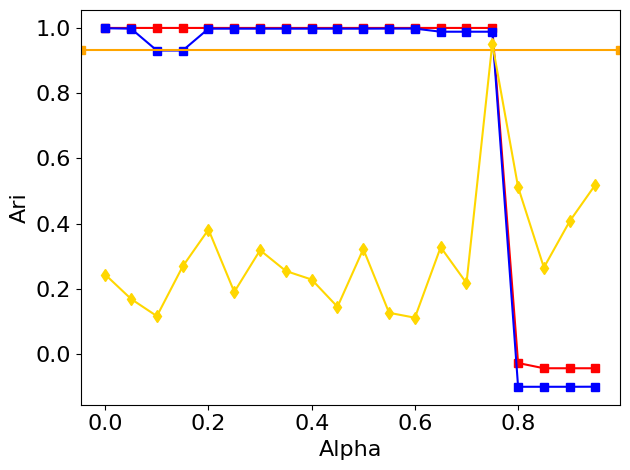

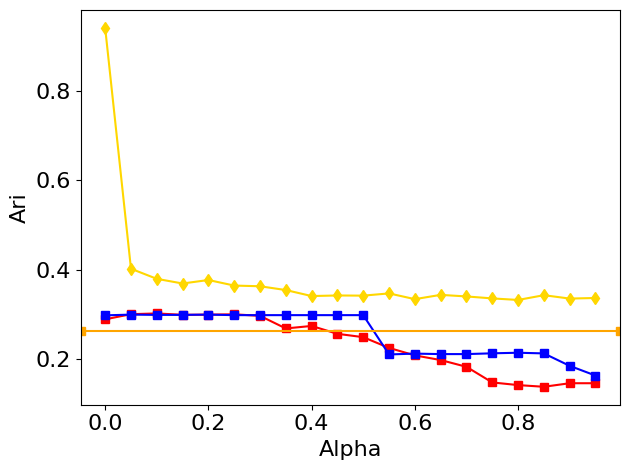

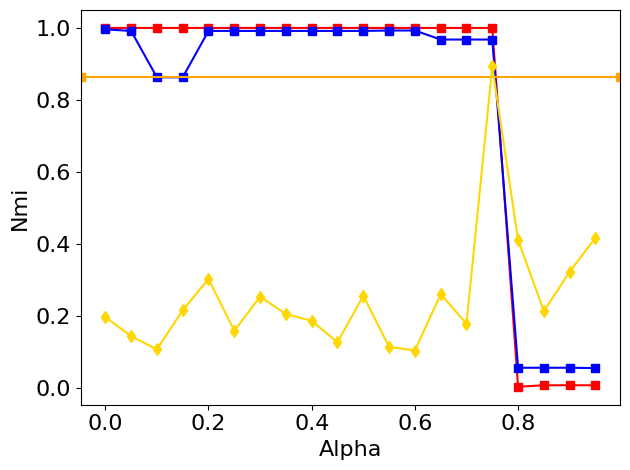

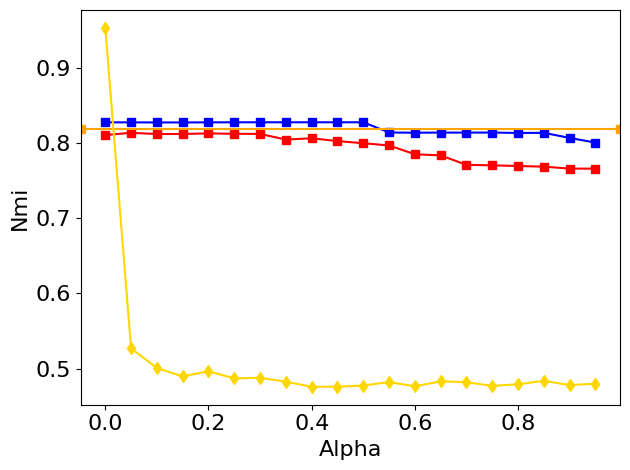

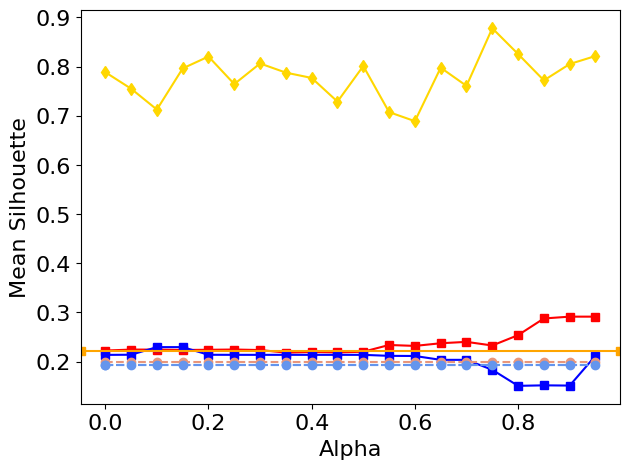

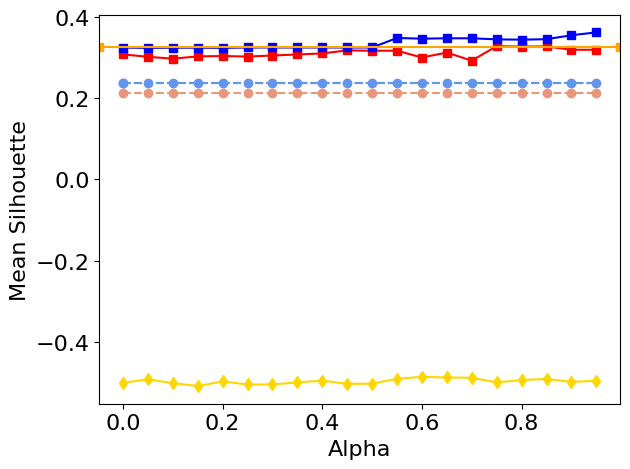

In [184]:
accuracy_metrics = ['ari', 'nmi', 'mean_silhouette']

for metric in accuracy_metrics:
    for s in sensitives:
        for ct in clustering_types:
            fig, axs = plt.subplots()
            # for FairDILCA
            for m, fm in contexts:
                df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['clustering_type']== ct) ]
                alphas = df['alpha']
                metric_data = df[metric+'_f']

                if fm=='FRR2':
                    axs.axhline(y=metric_data.tolist()[0], label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
                else:
                    axs.plot(alphas, metric_data, label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]['color'], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
            # for DILCA
            if metric != 'ari' and metric!= 'nmi':
                for m, fm in contexts[:2]:
                    df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['clustering_type']== ct)]
                    alphas = df['alpha']
                    metric_data = df[metric+'_nf']

                    axs.plot(alphas, metric_data, label=algos["DILCA_{}".format(m)]['label'], color=algos["DILCA_{}".format(m)]['color'], linestyle=algos["DILCA_{}".format(m)]["linestyle"], marker=algos["DILCA_{}".format(m)]["marker"])
                
            # for Competitors
            for m in ['M']:
                df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m) & (results_dilca_competitor['clustering_type']== ct)]
                alphas = results_dilca_fair_dilca['alpha'].unique()
                metric_data = df[metric+'_competitor']
                axs.plot(alphas, metric_data, label=algos[competitor]["label"], color=algos[competitor]["color"], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
            
            # df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== 'M')  & (results_dilca_competitor['clustering_type']== ct)]
            # metric_data = df[metric+'_dilca'].tolist()[0]
            # axs.axhline(y=metric_data, label=algos["NonFairOneHotEncoded"]["label"], color=algos["NonFairOneHotEncoded"]["color"], linestyle=algos["NonFairOneHotEncoded"]["linestyle"], marker=algos["NonFairOneHotEncoded"]["marker"])
            axs.tick_params(axis='x', labelsize=16)
            axs.tick_params(axis='y', labelsize=16) 
            axs.set_xlabel("Alpha", fontsize=16)
            axs.set_ylabel(metric.replace("_", " ").title(), fontsize=16)
            h, l = axs.get_legend_handles_labels()
            #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
            #fig.suptitle("{} ({}) - {} - {}".format(d, s, metric.replace("_", " ").title(), clust_algos[ct]["label"]))    
            fig.tight_layout()
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.png".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', dpi=300)
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.eps".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', format="eps", dpi=300)
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.pdf".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', format="pdf", dpi=300)
"""            break
        break
    break"""

'            break\n        break\n    break'

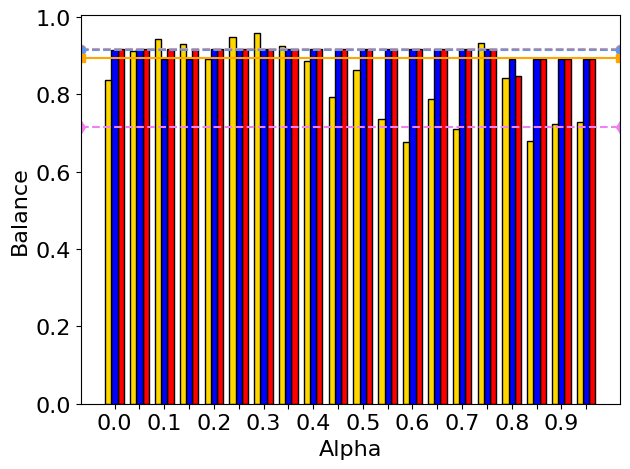

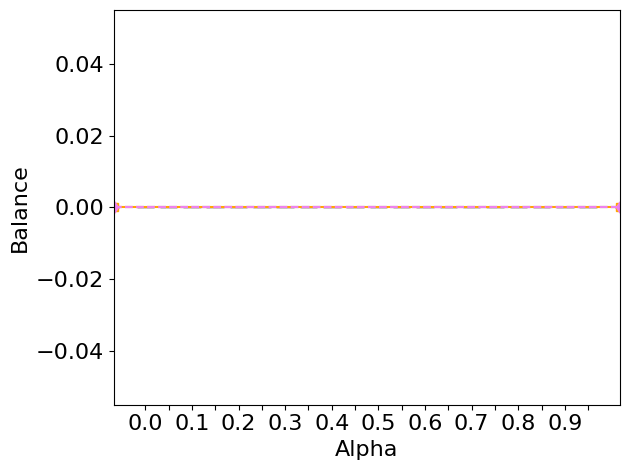

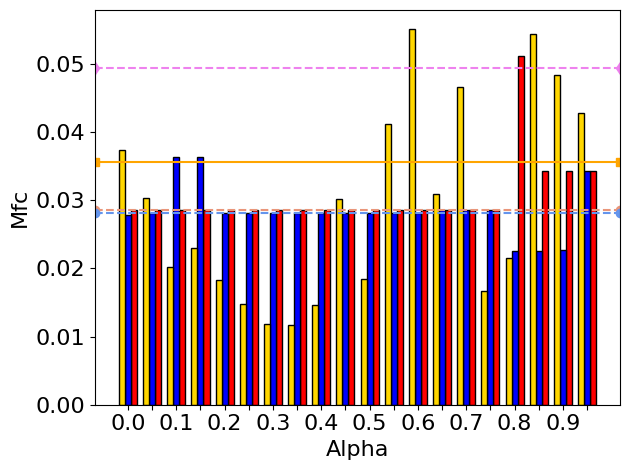

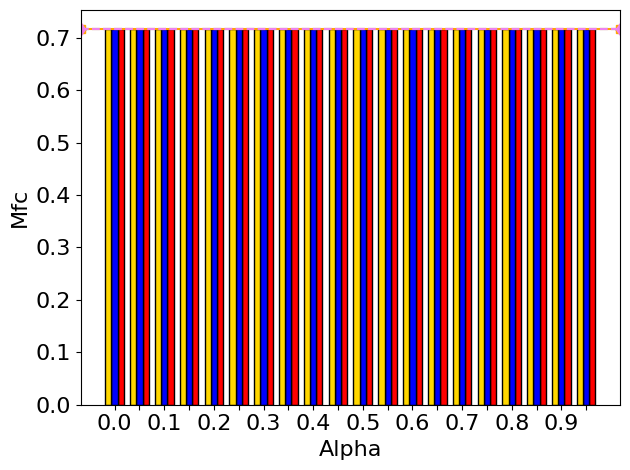

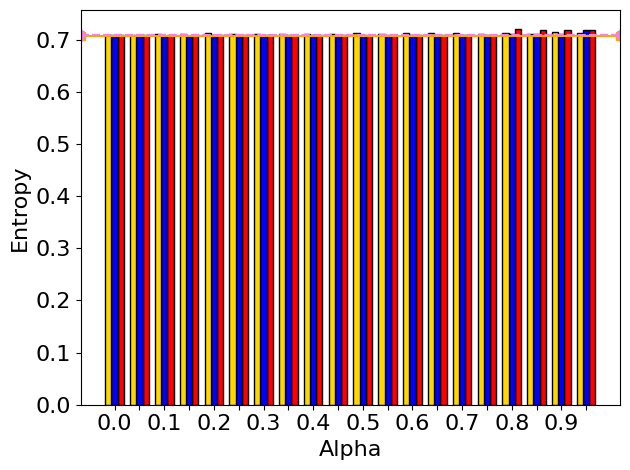

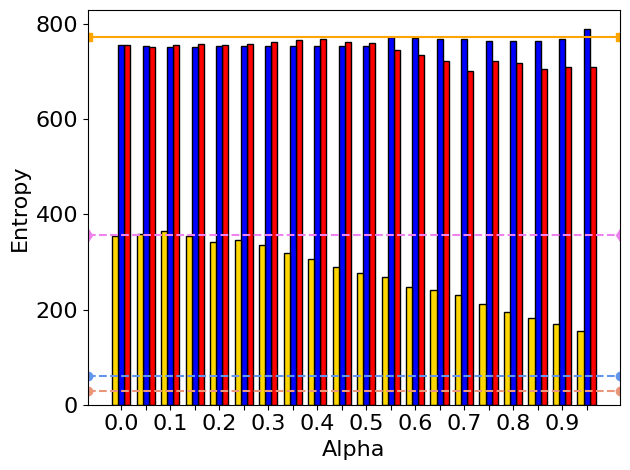

In [185]:
fairness_metrics = ["balance", "mfc", "entropy"]

for metric in fairness_metrics:
    for s in sensitives:
        for ct in clustering_types:
            fig, axs = plt.subplots()
            # DILCA
            for m, fm in contexts[:2]:
                df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['clustering_type']== ct)]
                metric_dilca = df[metric + "_sv_nf"].unique()
                axs.axhline(y=metric_dilca, label=algos["DILCA_{}".format(m)]['label'], color=algos["DILCA_{}".format(m)]['color'], linestyle=algos["DILCA_{}".format(m)]["linestyle"], marker=algos["DILCA_{}".format(m)]["marker"])
            # FairDILCA
            values_lists = []
            for m, fm in contexts[:2]:
                df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['clustering_type']== ct)]
                metric_fair_dilca = df[metric + "_sv_f"]
                
                alphas = df["alpha"]
                values_lists.append(metric_fair_dilca.to_list())
                
            df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== "FRR2") & (results_dilca_fair_dilca['method']== "RR") & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['clustering_type']== ct)]
            metric_fair_dilca = df[metric + "_sv_f"].unique()
            axs.axhline(y=metric_fair_dilca, label=algos["FairDILCA_{}".format("FRR2")]['label'], color=algos["FairDILCA_{}".format("FRR2")]['color'], linestyle=algos["FairDILCA_{}".format("FRR2")]["linestyle"], marker=algos["FairDILCA_{}".format("FRR2")]["marker"])
            # Competitor
            for m, fm in contexts[:1]:
                df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m)  & (results_dilca_competitor['clustering_type']== ct)]
                metric_competitor = df[metric + "_sv_competitor"]
                values_lists.append(metric_competitor.to_list())
            df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== 'M')  & (results_dilca_competitor['clustering_type']== ct)]
            metric_data = df[metric+'_sv_dilca'].tolist()[0]
            axs.axhline(y=metric_data, label=algos["NonFairOneHotEncoded"]["label"], color=algos["NonFairOneHotEncoded"]["color"], linestyle=algos["NonFairOneHotEncoded"]["linestyle"], marker=algos["NonFairOneHotEncoded"]["marker"])
            
            w = 1.0 # width
            num_x = len(alphas) # number of labels for x axis
            num_groups = len(contexts) 
            first_tick = int(math.ceil((num_groups*w/2)))
            gap = num_groups*w + 1
            x = np.array([first_tick + ix*gap for ix in range(num_x)])

            b = []
            for ig in range(num_groups):
                # per non prendere FRR2
                if ig==2: index = competitor
                else: index = [a for a in algos.keys()][2+ig]
                b.append(axs.bar(x - (ig - num_groups/2 + 0.5)*w, 
                        values_lists[ig], 
                        width=w, 
                        align='center', 
                        edgecolor = 'black', 
                        linewidth = 1.0,
                        label = algos[index]["label"],
                        color = algos[index]["color"]
                        ))
            axs.tick_params(axis='x', labelsize=16)
            axs.tick_params(axis='y', labelsize=16) 
            axs.set_ylabel(metric.replace("_", " ").title(), fontsize=16)
            axs.set_xlabel('Alpha', fontsize=16)
            axs.set_xticks(x)
            
            new = []
            for i, a in enumerate(alphas):
                if i%2==1:new.append("")
                else: new.append(a)
            
            axs.set_xticklabels([str(a) for a in new])
            h, l = axs.get_legend_handles_labels()
            #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
            #fig.suptitle("{} ({}) - {} - {}".format(d, s, metric.replace("_", " ").title(), clust_algos[ct]["label"]))    
            fig.tight_layout()
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.png".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', dpi=300)
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.eps".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', format="eps", dpi=300)
            fig.savefig("out/results/competitors/{}/test_clustering_{}_{}_{}_{}.pdf".format(d, d, s, clust_algos[ct]["label"], metric), bbox_inches='tight', format="pdf", dpi=300)
"""            break
        break
    break"""

## KNN

In [186]:

filename_dilca_fair_dilca = path_exps + "exps_{}_knn.csv".format(d)
filename_dilca_competitor = path_competitors + "knn_{}_{}.csv".format(d, competitor)

results_dilca_fair_dilca = pd.read_pickle(filename_dilca_fair_dilca)
results_dilca_competitor = pd.read_pickle(filename_dilca_competitor)
results_dilca_competitor = results_dilca_competitor.rename(columns={"demographic_ratio_competitor": "demographic_parity_ratio_competitor", "demographic_ratio_dilca": "demographic_parity_ratio_dilca"})

sensitives = [s for s in results_dilca_fair_dilca['sensitive'].unique()]
sensitives2 = [s for s in results_dilca_competitor['sensitive'].unique()]
ks = [s for s in results_dilca_fair_dilca['k'].unique()]
ks2 = [s for s in results_dilca_fair_dilca['k'].unique()]
print(sensitives==sensitives2)
print(ks==ks2)

True
True


/var/folders/p0/56c71d2n0bg3czx0r3rs_wsh0000gn/T/ipykernel_1407/43487573.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots()


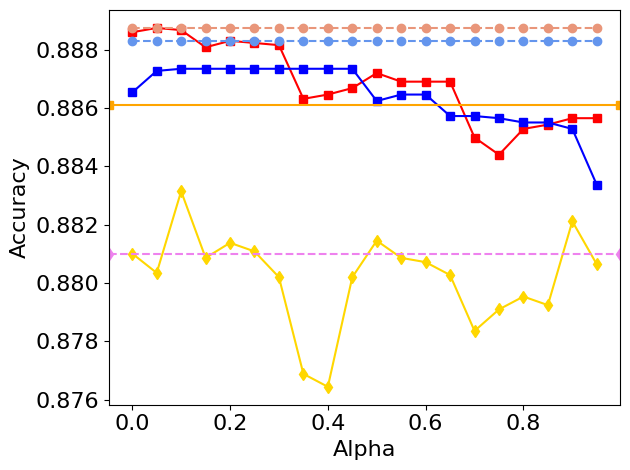

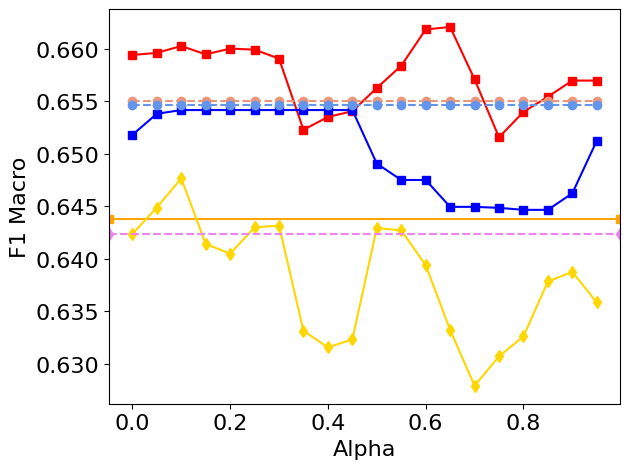

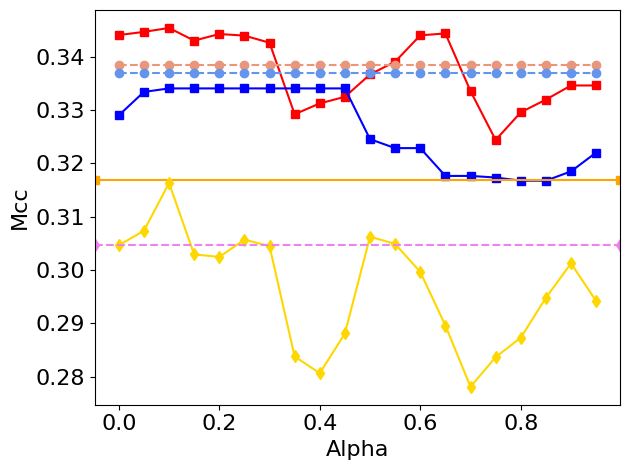

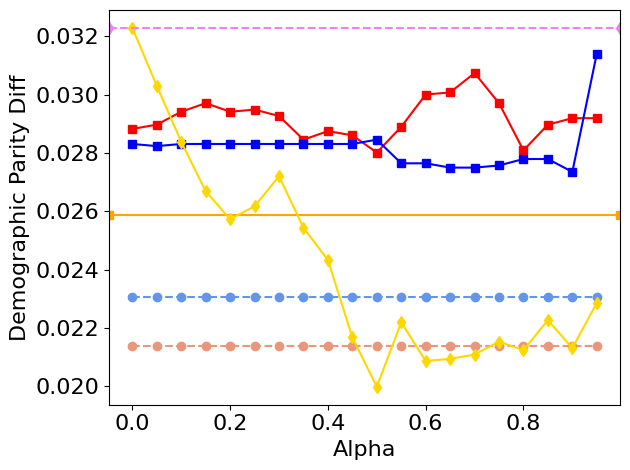

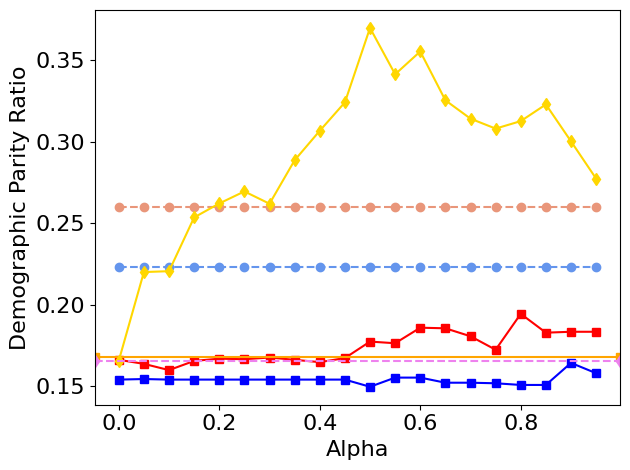

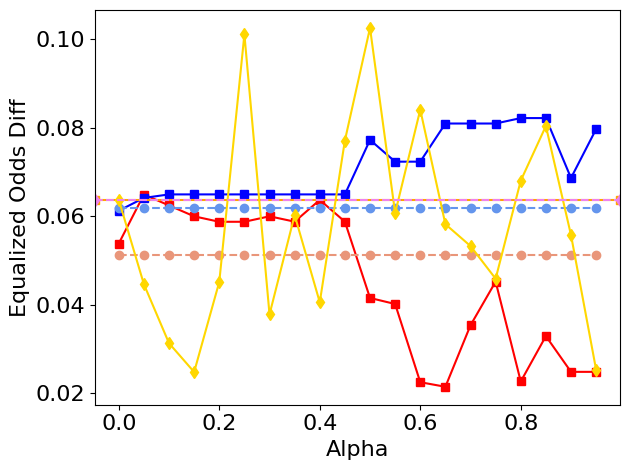

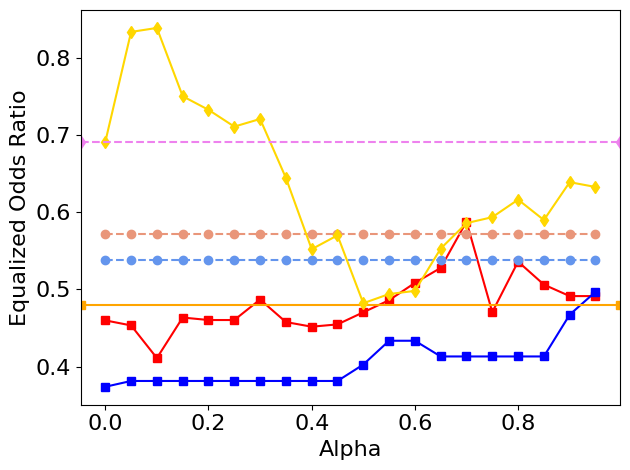

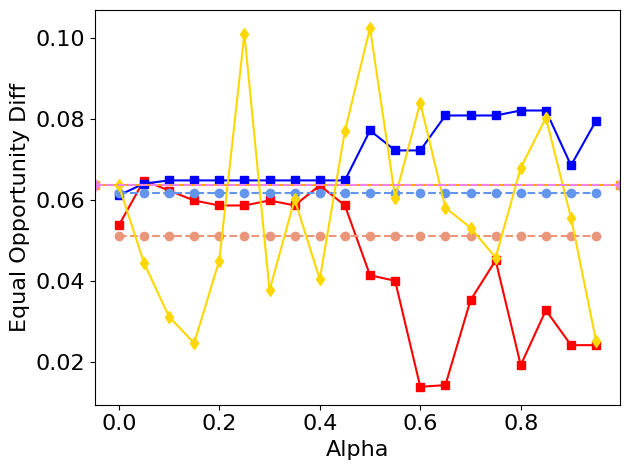

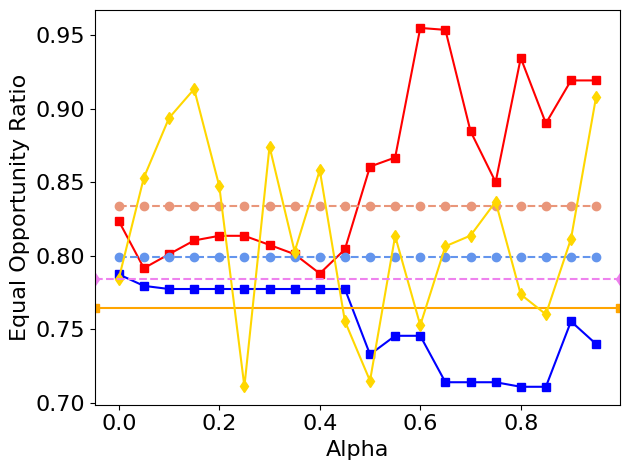

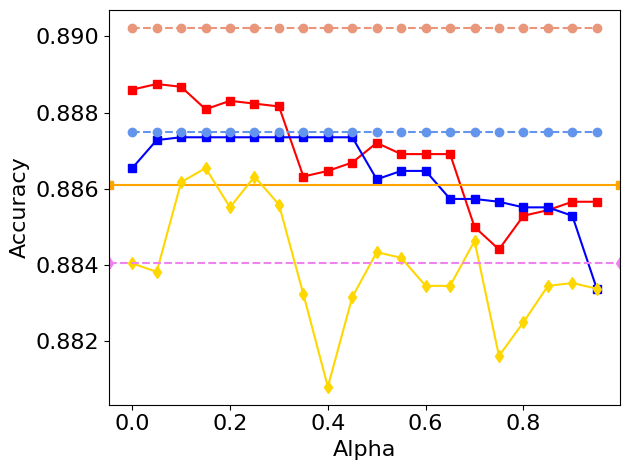

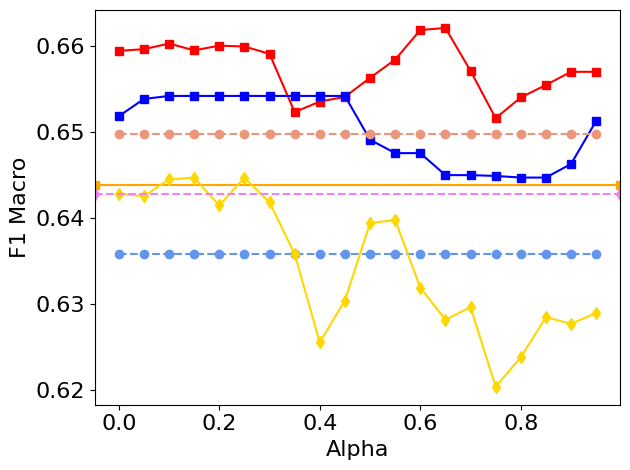

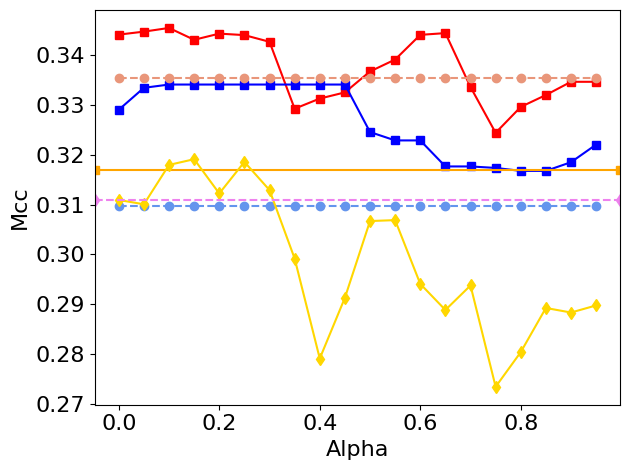

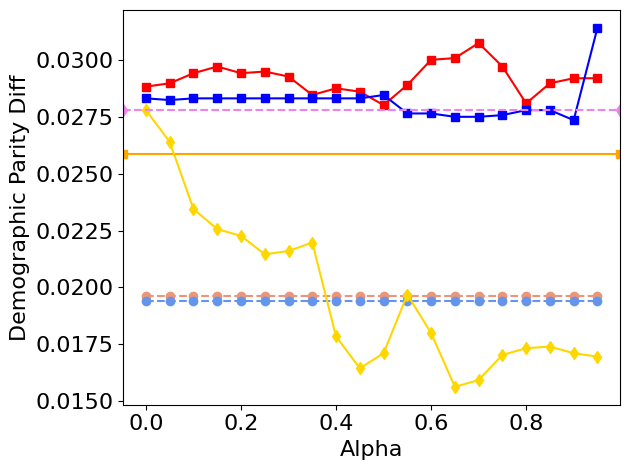

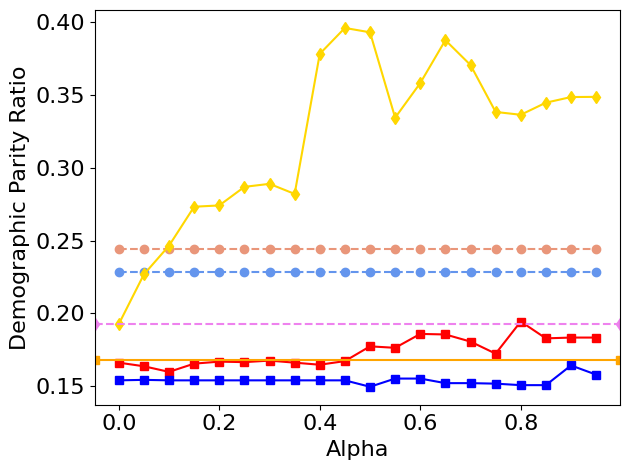

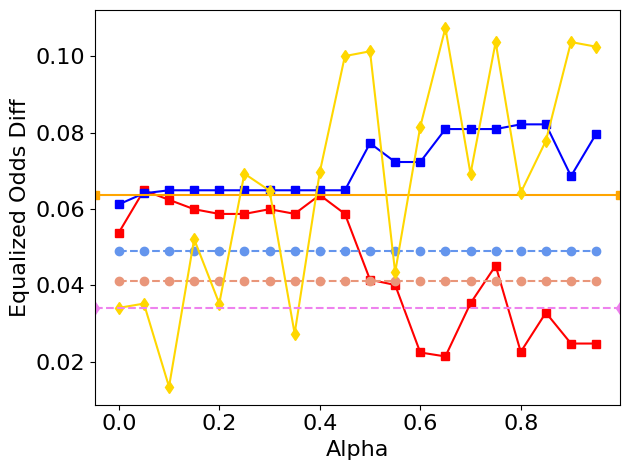

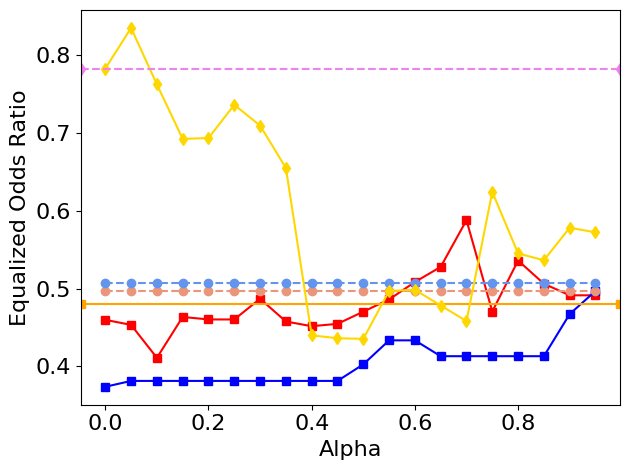

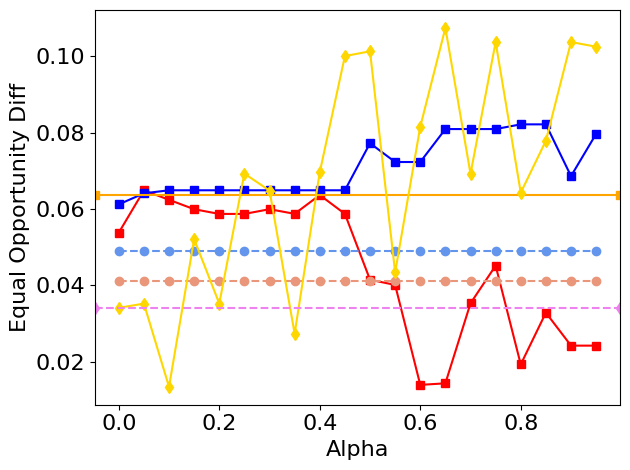

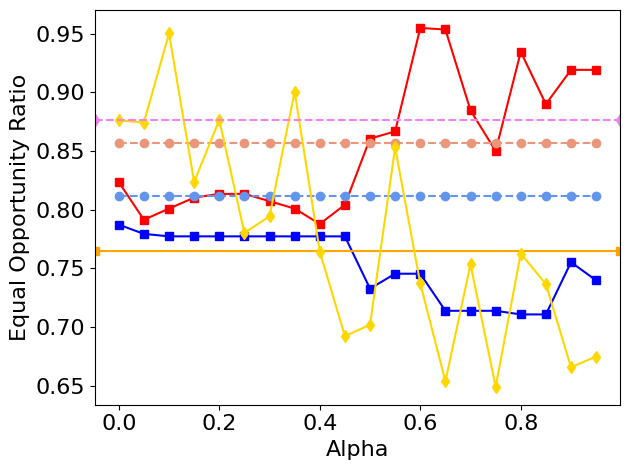

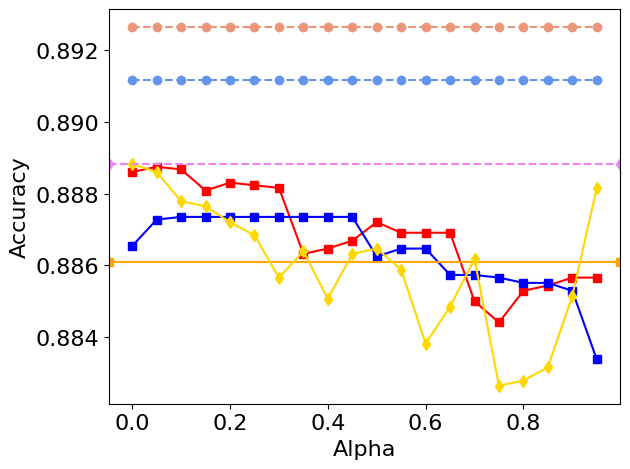

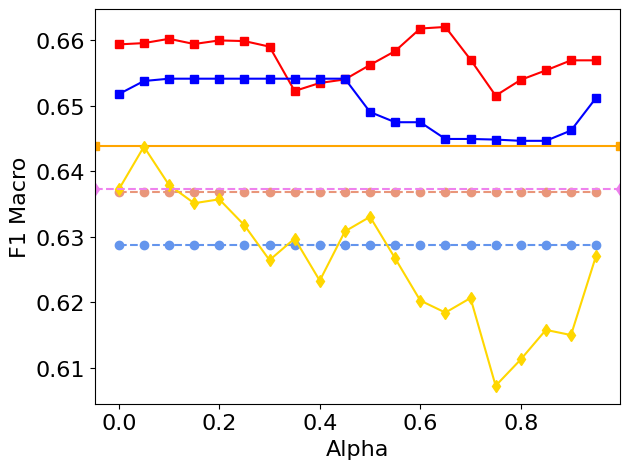

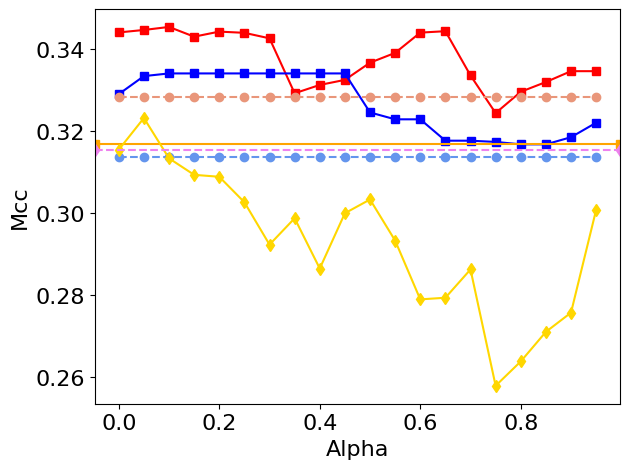

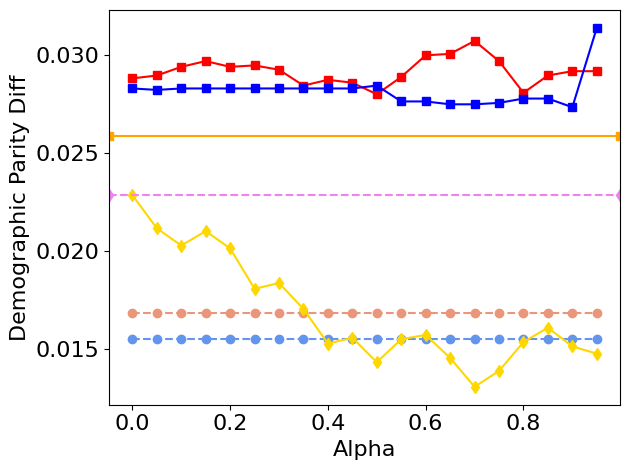

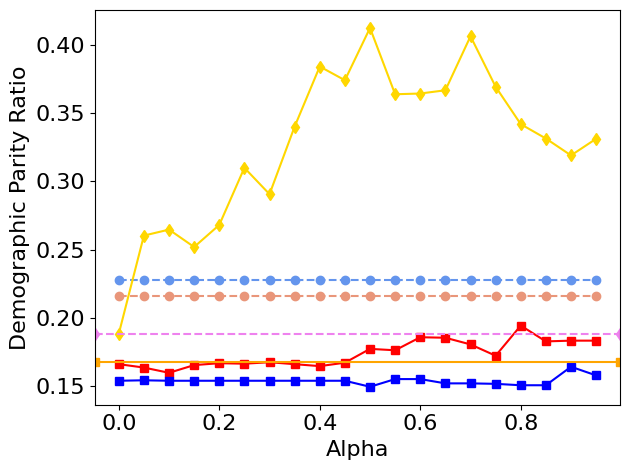

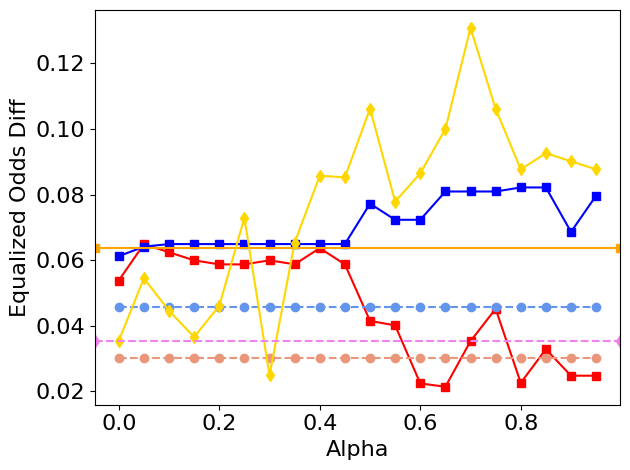

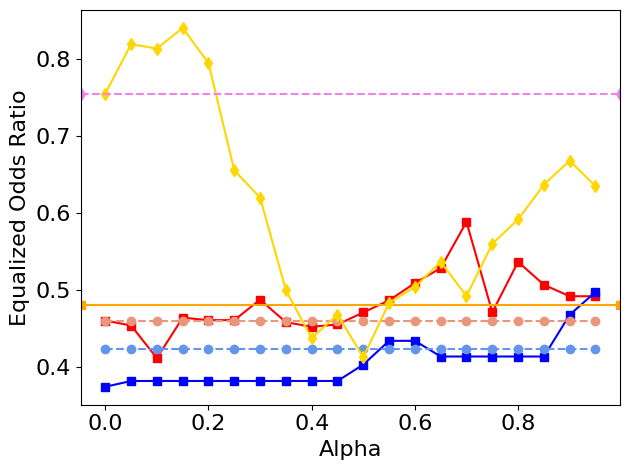

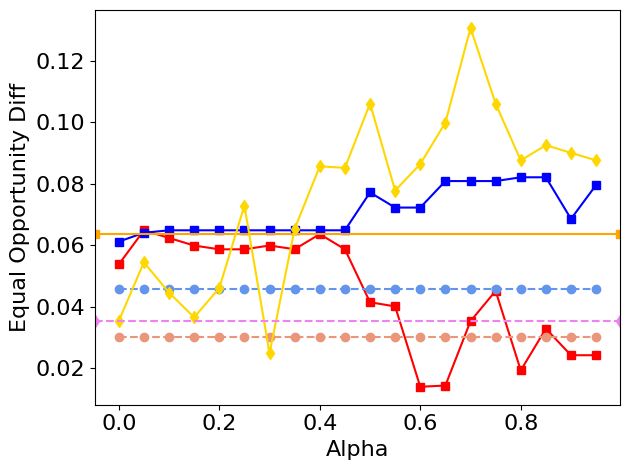

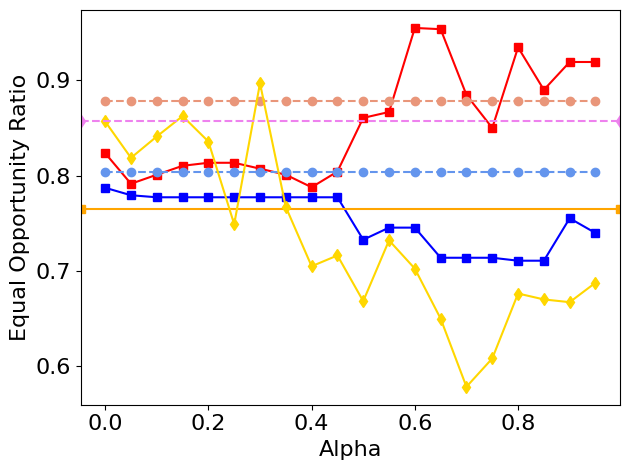

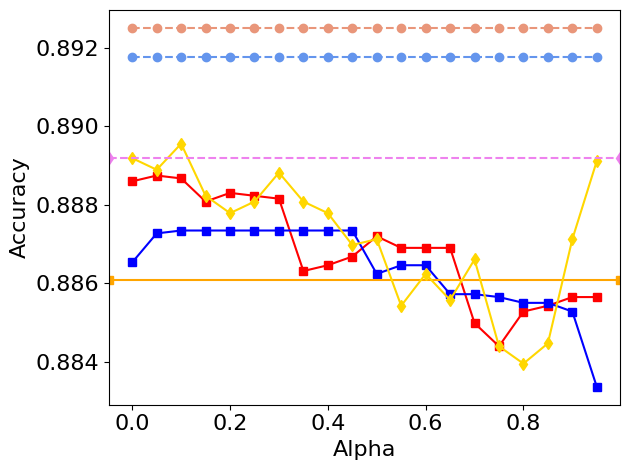

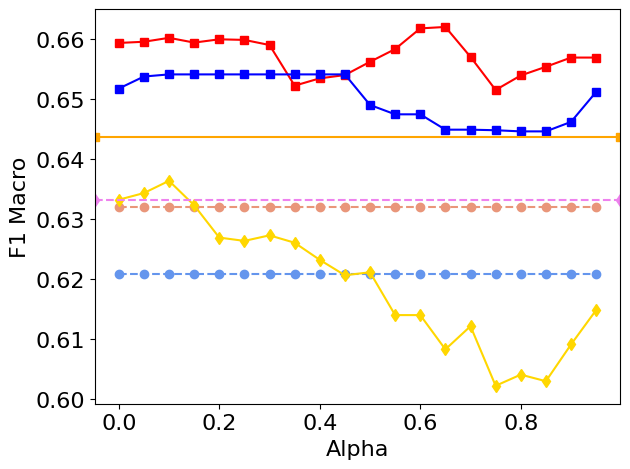

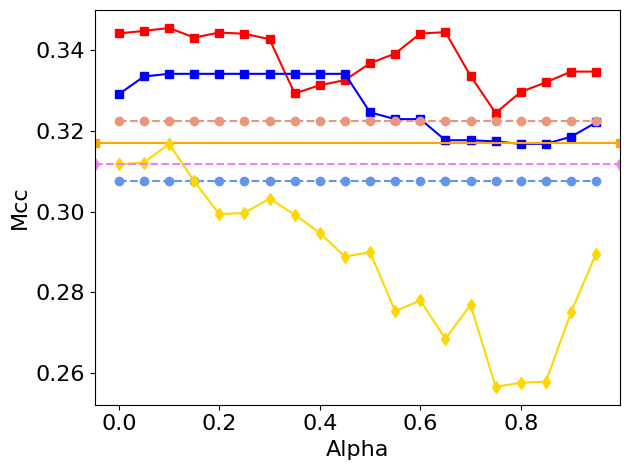

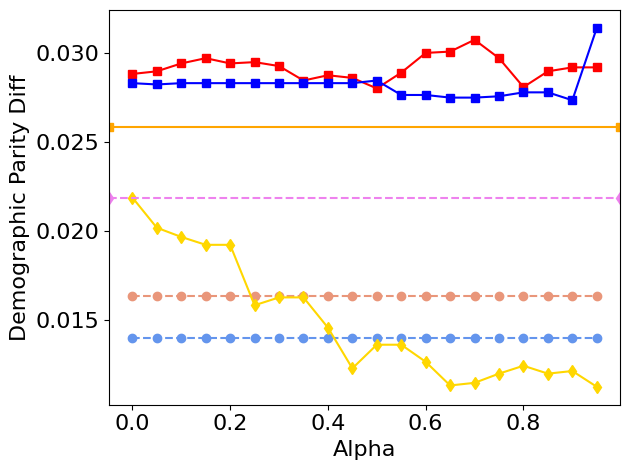

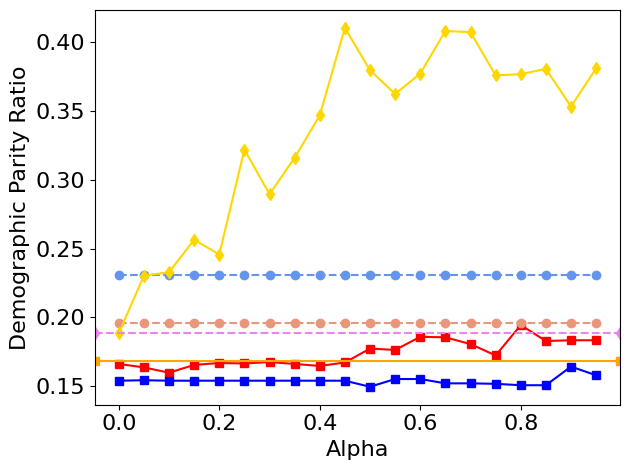

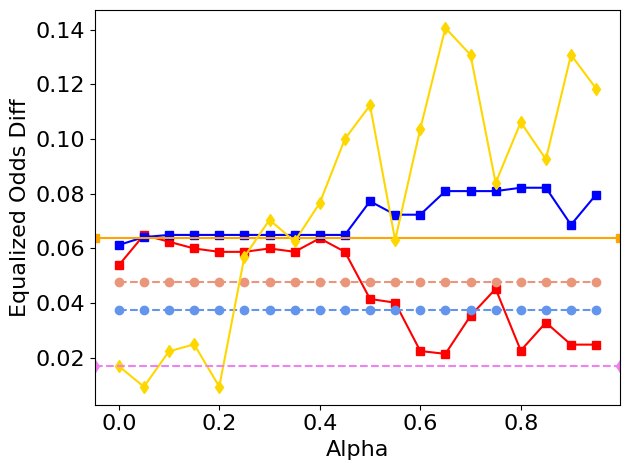

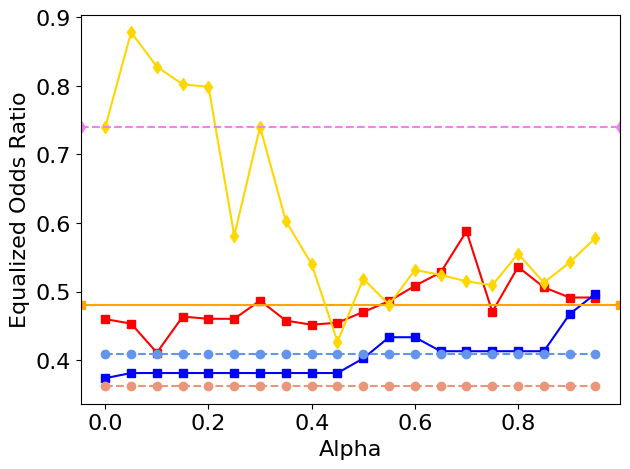

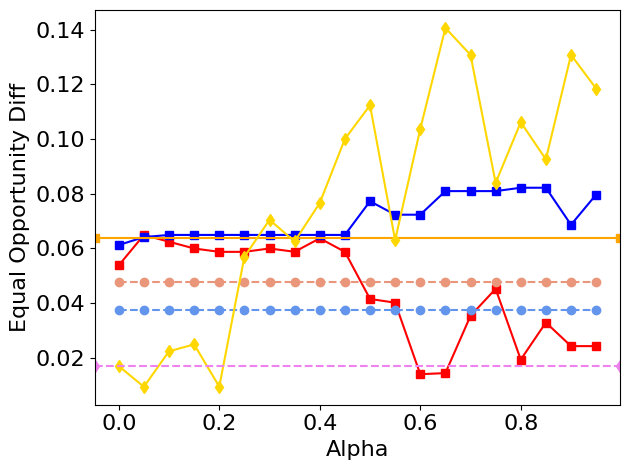

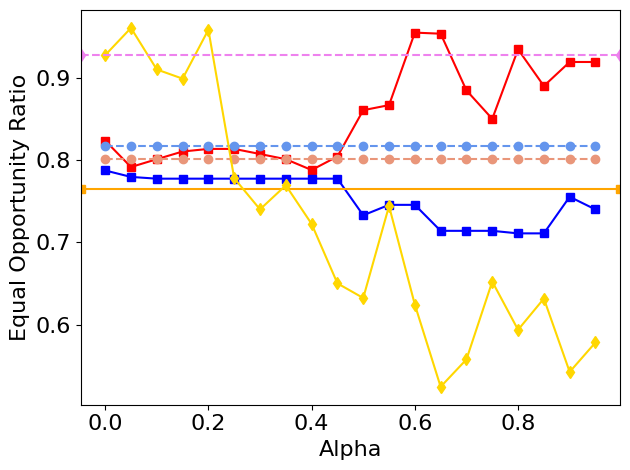

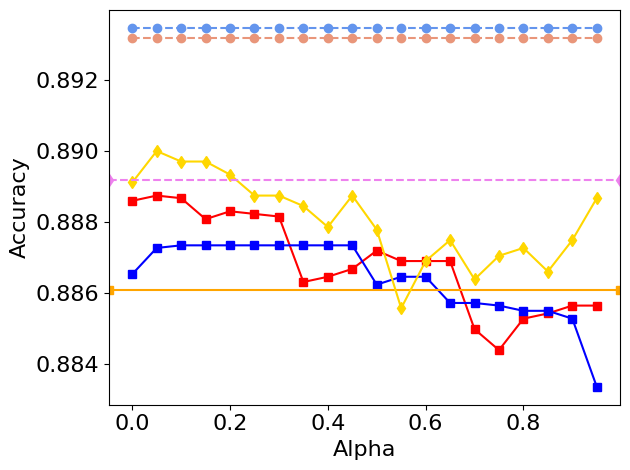

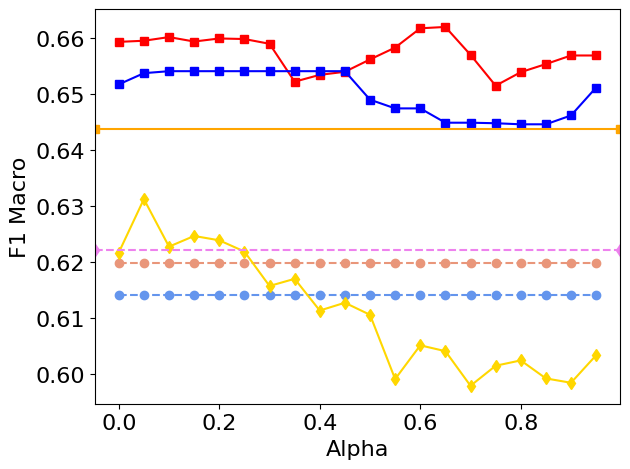

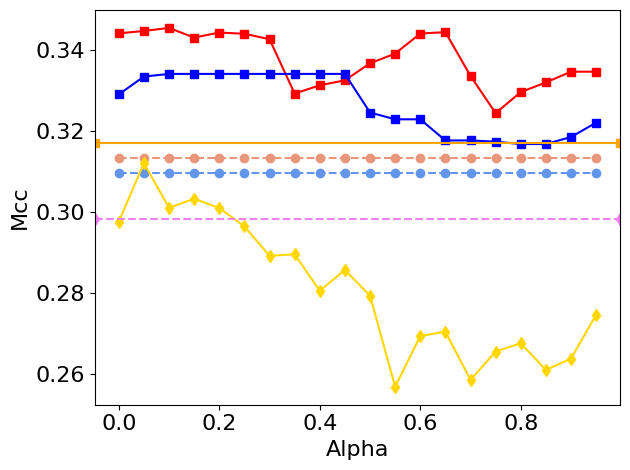

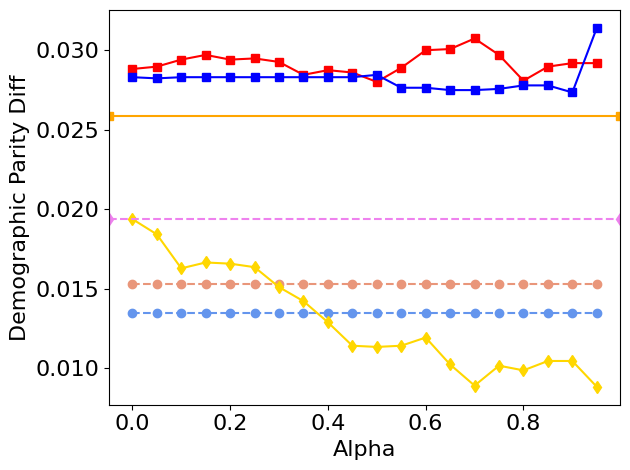

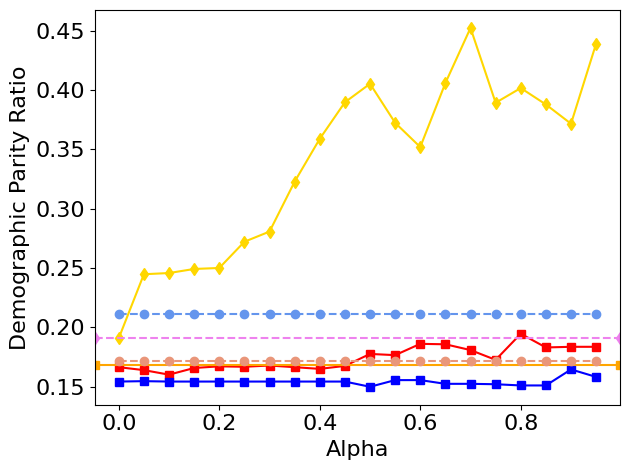

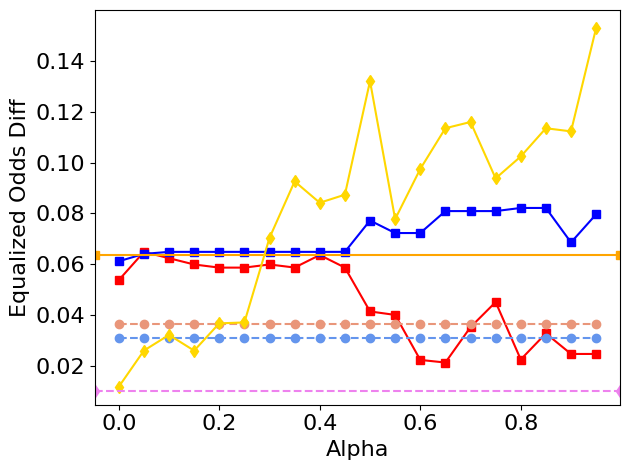

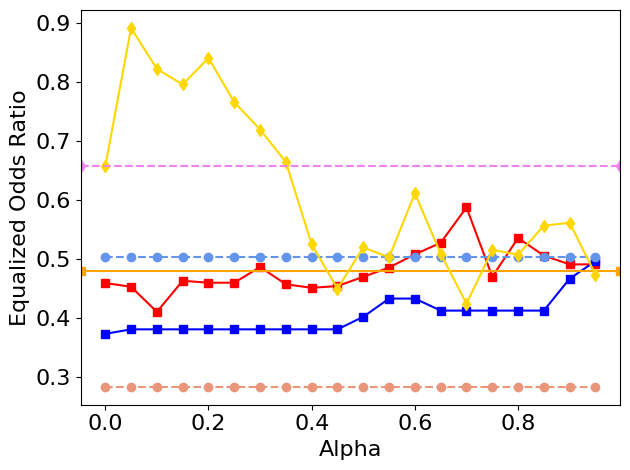

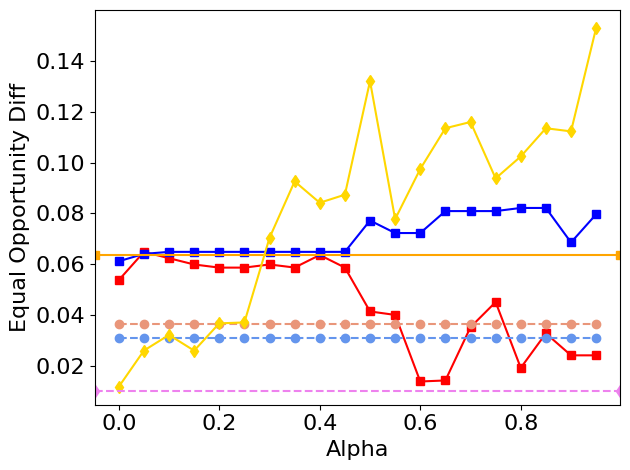

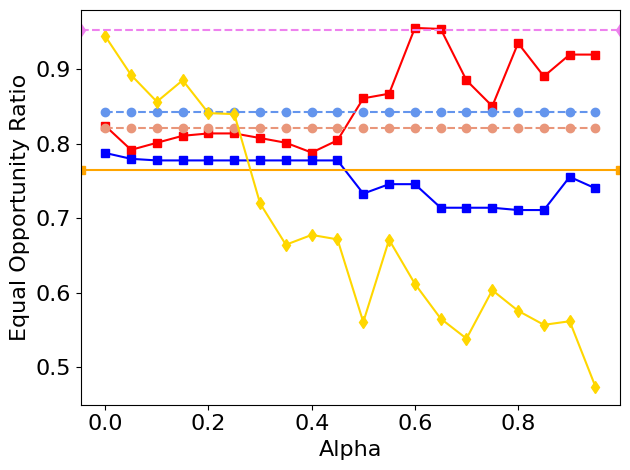

In [187]:
metrics = ['accuracy', 'f1_macro', 'mcc', 'demographic_parity_diff', 'demographic_parity_ratio', 'equalized_odds_diff', 'equalized_odds_ratio', 'equal_opportunity_diff', 'equal_opportunity_ratio']

for k in ks:
    for metric in metrics:
        for s in sensitives:
            fig, axs = plt.subplots()
            # for FairDILCA 
            for m, fm in contexts:
                df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['k']== k)]
                alphas = df['alpha']
                metric_data = df[metric+'_f']

                if fm=='FRR2':
                    axs.axhline(y=metric_data.tolist()[0], label=algos["FairDILCA_FRR2"]["label"], color=algos["FairDILCA_FRR2"]["color"], linestyle=algos["FairDILCA_FRR2"]["linestyle"], marker=algos["FairDILCA_FRR2"]["marker"])
                else:
                    axs.plot(alphas, metric_data, label=algos["FairDILCA_{}".format(fm)]["label"], color=algos["FairDILCA_{}".format(fm)]["color"], linestyle=algos["FairDILCA_{}".format(fm)]["linestyle"], marker=algos["FairDILCA_{}".format(fm)]["marker"])
            # for DILCA
            for m, fm in contexts[:2]:
                df = results_dilca_fair_dilca[(results_dilca_fair_dilca['sensitive']== s) & (results_dilca_fair_dilca['method']== m) & (results_dilca_fair_dilca['fair_method']== fm) & (results_dilca_fair_dilca['mode']== 'CD') & (results_dilca_fair_dilca['k']== k)]
                alphas = df['alpha']
                metric_data = df[metric+'_nf']

                axs.plot(alphas, metric_data, label=algos["DILCA_{}".format(m)]["label"], color=algos["DILCA_{}".format(m)]["color"], linestyle=algos["DILCA_{}".format(m)]["linestyle"], marker=algos["DILCA_{}".format(m)]["marker"])  
            # for Competitors
            for m in ['M']:
                df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== m)  & (results_dilca_competitor['k']== k)]
                alphas = results_dilca_fair_dilca['alpha'].unique()
                metric_data = df[metric+'_competitor']
                axs.plot(alphas, metric_data, label=algos[competitor]["label"], color=algos[competitor]['color'], linestyle=algos[competitor]["linestyle"], marker=algos[competitor]["marker"])
            df = results_dilca_competitor[(results_dilca_competitor['sensitive']== s) & (results_dilca_competitor['method']== 'M')  & (results_dilca_competitor['k']== k)]
            metric_data = df[metric+'_dilca'].unique()
            axs.axhline(y=metric_data.tolist()[0], label=algos["NonFairOneHotEncoded"]["label"], color=algos["NonFairOneHotEncoded"]["color"], linestyle=algos["NonFairOneHotEncoded"]["linestyle"], marker=algos["NonFairOneHotEncoded"]["marker"])
            axs.tick_params(axis='x', labelsize=16)
            axs.tick_params(axis='y', labelsize=16) 
            axs.set_xlabel("Alpha", fontsize=16)
            axs.set_ylabel(metric.replace("_", " ").title(), fontsize=16)
            h, l = axs.get_legend_handles_labels()
            #fig.legend(h, l,loc='upper center', bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=True, ncol=len(algos.keys()))  
            #fig.suptitle("{} ({}) k={} - {}".format(d, s, k, metric.replace("_", " ").title()))    
            fig.tight_layout()
            fig.savefig("out/results/competitors/{}/test_knn_{}_{}_k{}_{}.png".format(d, d, s, k, metric), bbox_inches='tight', dpi=300)
            fig.savefig("out/results/competitors/{}/test_knn_{}_{}_k{}_{}.eps".format(d, d, s, k, metric), bbox_inches='tight', format="eps", dpi=300)
            fig.savefig("out/results/competitors/{}/test_knn_{}_{}_k{}_{}.pdf".format(d, d, s, k, metric), bbox_inches='tight', format="pdf", dpi=300)

## Legends

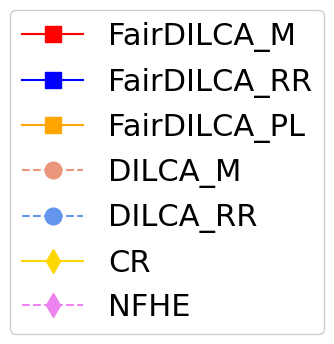

In [188]:
handles,labels = axs.get_legend_handles_labels()
empty_fig, axe = plt.subplots(figsize=(1, 1))
axe.legend(handles, labels, loc="center", framealpha=1, frameon=True, prop={'size': 22}, markerscale=2)
axe.xaxis.set_visible(False)
axe.yaxis.set_visible(False)
for v in axe.spines.values():
	v.set_visible(False)
 
empty_fig.savefig("out/results/competitors/{}/legend.png".format(d), dpi=300, bbox_inches='tight')
empty_fig.savefig("out/results/competitors/{}/legend.pdf".format(d), dpi=300, bbox_inches='tight', format='pdf')


/Users/alessiofamiani/Library/Python/3.9/lib/python/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/alessiofamiani/Library/Python/3.9/lib/python/site-packages/matplotlib/_tight_bbox.py:68: RuntimeWarning: divide by zero encountered in scalar divide
  fig.bbox.width / w1, fig.bbox.height / h1)
/Users/alessiofamiani/Library/Python/3.9/lib/python/site-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in scalar add
  y1 = self.convert_yunits(self._y0 + self._height)
/Users/alessiofamiani/Library/Python/3.9/lib/python/site-packages/matplotlib/transforms.py:2050: RuntimeWarning: invalid value encountered in scalar add
  self._mtx[1, 2] += ty
/Users/alessiofamiani/Library/Python/3.9/lib/python/site-packages/matplotlib/_tight_bbox.py:67: RuntimeWarning: divide by zero encountered in scalar divide
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/Users/alessiofamiani/Libra

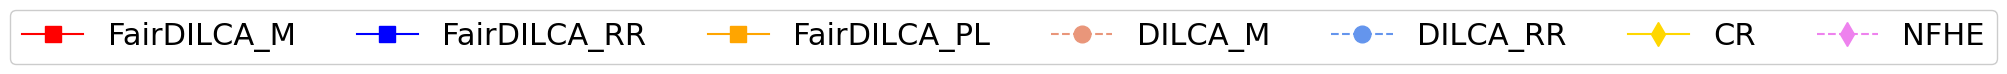

In [189]:
handles,labels = axs.get_legend_handles_labels()
empty_fig, axe = plt.subplots(figsize=(1, 0))
axe.legend(handles, labels, loc="center", framealpha=1, frameon=True, bbox_to_anchor=(0.5, 0.00), fancybox=True, shadow=False, ncol=7, prop={'size': 22}, markerscale=2)
axe.xaxis.set_visible(False)
axe.yaxis.set_visible(False)
for v in axe.spines.values():
	v.set_visible(False)
 
empty_fig.savefig("out/results/competitors/{}/legend_.png".format(d), dpi=300, bbox_inches='tight')
empty_fig.savefig("out/results/competitors/{}/legend_.pdf".format(d), dpi=300, bbox_inches='tight', format='pdf')


In [190]:
pd.read_pickle("out/results/competitors/exps_bank_marketing_CorrelationRemover.csv")

dataset  objs_no  n_bins method       sensitive  \
1   bank_marketing    45211       5         marital_status   
2   bank_marketing    45211       5         marital_status   
3   bank_marketing    45211       5         marital_status   
4   bank_marketing    45211       5         marital_status   
5   bank_marketing    45211       5         marital_status   
6   bank_marketing    45211       5         marital_status   
7   bank_marketing    45211       5         marital_status   
8   bank_marketing    45211       5         marital_status   
9   bank_marketing    45211       5         marital_status   
10  bank_marketing    45211       5         marital_status   
11  bank_marketing    45211       5         marital_status   
12  bank_marketing    45211       5         marital_status   
13  bank_marketing    45211       5         marital_status   
14  bank_marketing    45211       5         marital_status   
15  bank_marketing    45211       5         marital_status   
16  bank_marketing    45211       5         marital_status   
17  bank_marketing    45211       5         marital_status   
18  bank_marketing    45211       5         marital_status   
19  bank_marketing    45211       5         marital_status   
20  bank_marketing    45211       5         marital_status   

            competitor competitor_params                       groups  \
1   CorrelationRemover    {'alpha': 0.0}  [married, single, divorced]   
2   CorrelationRemover   {'alpha': 0.05}  [married, single, divorced]   
3   CorrelationRemover    {'alpha': 0.1}  [married, single, divorced]   
4   CorrelationRemover   {'alpha': 0.15}  [married, single, divorced]   
5   CorrelationRemover    {'alpha': 0.2}  [married, single, divorced]   
6   CorrelationRemover   {'alpha': 0.25}  [married, single, divorced]   
7   CorrelationRemover    {'alpha': 0.3}  [married, single, divorced]   
8   CorrelationRemover   {'alpha': 0.35}  [married, single, divorced]   
9   CorrelationRemover    {'alpha': 0.4}  [married, single, divorced]   
10  CorrelationRemover   {'alpha': 0.45}  [married, single, divorced]   
11  CorrelationRemover    {'alpha': 0.5}  [married, single, divorced]   
12  CorrelationRemover   {'alpha': 0.55}  [married, single, divorced]   
13  CorrelationRemover    {'alpha': 0.6}  [married, single, divorced]   
14  CorrelationRemover   {'alpha': 0.65}  [married, single, divorced]   
15  CorrelationRemover    {'alpha': 0.7}  [married, single, divorced]   
16  CorrelationRemover   {'alpha': 0.75}  [married, single, divorced]   
17  CorrelationRemover    {'alpha': 0.8}  [married, single, divorced]   
18  CorrelationRemover   {'alpha': 0.85}  [married, single, divorced]   
19  CorrelationRemover    {'alpha': 0.9}  [married, single, divorced]   
20  CorrelationRemover   {'alpha': 0.95}  [married, single, divorced]   

   majority_group          groups_sizes  ...  \
1         married  [27214, 12790, 5207]  ...   
2         married  [27214, 12790, 5207]  ...   
3         married  [27214, 12790, 5207]  ...   
4         married  [27214, 12790, 5207]  ...   
5         married  [27214, 12790, 5207]  ...   
6         married  [27214, 12790, 5207]  ...   
7         married  [27214, 12790, 5207]  ...   
8         married  [27214, 12790, 5207]  ...   
9         married  [27214, 12790, 5207]  ...   
10        married  [27214, 12790, 5207]  ...   
11        married  [27214, 12790, 5207]  ...   
12        married  [27214, 12790, 5207]  ...   
13        married  [27214, 12790, 5207]  ...   
14        married  [27214, 12790, 5207]  ...   
15        married  [27214, 12790, 5207]  ...   
16        married  [27214, 12790, 5207]  ...   
17        married  [27214, 12790, 5207]  ...   
18        married  [27214, 12790, 5207]  ...   
19        married  [27214, 12790, 5207]  ...   
20        married  [27214, 12790, 5207]  ...   

                                  means_competitor_nn  \
1   [2226.982375810628, 2132.453155733305, 2103.47...   
2   [2226.9823758106268, 2132.332540762747, 2100.2.